In [6]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [7]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [8]:
import os

data_path = "data/features/synthbuster/standard"
suffix = "features/extraction_params/train_test/features_RGB.csv"
dalle2 = pd.read_csv(os.path.join(data_path, "dalle2", suffix), index_col=0)
dalle3 = pd.read_csv(os.path.join(data_path, "dalle3", suffix), index_col=0)
firefly = pd.read_csv(os.path.join(data_path, "firefly", suffix), index_col=0)
glide = pd.read_csv(os.path.join(data_path, "glide", suffix), index_col=0)
img = pd.read_csv(os.path.join(data_path, "img", suffix), index_col=0)
midjourney = pd.read_csv(os.path.join(data_path, "midjourney-v5", suffix), index_col=0)
sd_1_3 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-3", suffix), index_col=0)
sd_1_4 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-4", suffix), index_col=0)
sd_2 = pd.read_csv(os.path.join(data_path, "stable-diffusion-2", suffix), index_col=0)
sd_xl = pd.read_csv(os.path.join(data_path, "stable-diffusion-xl", suffix), index_col=0)

In [9]:
datasets_train = {
    "dalle2": dalle2,
    "dalle3": dalle3,
    "firefly": firefly,
    "glide": glide,
    "midjourney": midjourney,
    "sd_1_3": sd_1_3,
    "sd_1_4": sd_1_4,
    "sd_2": sd_2,
    "sd_xl": sd_xl,
}


dir_names = {
    "dalle2": "dalle2",
    "dalle3": "dalle3",
    "firefly": "firefly",
    "glide": "glide",
    "midjourney": "midjourney-v5",
    "sd_1_3": "stable-diffusion-1-3",
    "sd_1_4": "stable-diffusion-1-4",
    "sd_2": "stable-diffusion-2",
    "sd_xl": "stable-diffusion-xl",
}

In [10]:
jpg_path = "data/features/synthbuster_jpg/jpg_quality_80"
gauss_path = "data/features/synthbuster_gauss/sigma_2"
for dataset_name, dataset in datasets_train.items():
    datasets_train[dataset_name] = pd.concat([datasets_train[dataset_name], 
                                              img,
                                              pd.read_csv(os.path.join(jpg_path, dir_names[dataset_name], suffix), index_col=0),
                                              pd.read_csv(os.path.join(jpg_path, "img", suffix), index_col=0),
                                              pd.read_csv(os.path.join(gauss_path, dir_names[dataset_name], suffix), index_col=0),
                                              pd.read_csv(os.path.join(gauss_path, "img", suffix), index_col=0)])

In [11]:
import os
data_path = "data/features/genimage-512x512/jpg100"
suffix = "features/extraction_params/train/features_RGB.csv"
gen_biggan_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan", suffix), index_col=0)
gen_vqdm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm", suffix), index_col=0)
gen_sdv5_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5", suffix), index_col=0)
gen_wukong_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong", suffix), index_col=0)
gen_adm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm", suffix), index_col=0)
gen_glide_train = pd.read_csv(os.path.join(data_path, "imagenet_glide", suffix), index_col=0)
gen_midjourney_train = pd.read_csv(os.path.join(data_path, "imagenet_midjourney", suffix), index_col=0)
# gen_mid_sd = pd.concat([sdv5_train, midjourney_train])
# gen_combined_train = pd.concat([biggan_train, vqdm_train, sdv5_train, wukong_train, adm_train, glide_train, midjourney_train])

datasets_train["gen_biggan"] = gen_biggan_train
datasets_train["gen_vqdm"] = gen_vqdm_train
datasets_train["gen_sdv5"] = gen_sdv5_train
datasets_train["gen_wukong"] = gen_wukong_train
datasets_train["gen_adm"] = gen_adm_train
datasets_train["gen_glide"] = gen_glide_train
datasets_train["gen_midjourney"] = gen_midjourney_train


## Data preparation

In [12]:
def drop_columns(df, drop_only_diagnostic=False):
    to_drop = list()
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            to_drop.append(column)
        elif 'diagnostics' in column:
            to_drop.append(column)
        elif 'Mask' in column:
            to_drop.append(column)
    df.drop(to_drop, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [13]:
# We drop only columns from train set
for key, df in datasets_train.items():
    preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [14]:
from sklearn.model_selection import train_test_split

X_train = {}
X_val = {}
X_test = {}

y_train = {}
y_val = {}
y_test = {}

Image_train = {}
Image_val = {}

for key, df in datasets_train.items():
    X = df.drop('Category', axis=1)
    y = df['Category']
    
    # get train, val and test sets
    X_train[key], X_test[key], y_train[key], y_test[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
    X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X_train[key], y_train[key], test_size=0.2, random_state=SEED)
    
    Image_train[key] = X_train[key]['Image']
    Image_val[key] = X_val[key]['Image']
    
    X_train[key] = X_train[key].drop('Image', axis=1)
    X_val[key] = X_val[key].drop('Image', axis=1)
    
# create dataset combining all train sets
# X_train_all = pd.concat([X_train[key] for key in datasets_train.keys()])
# y_train_all = pd.concat([y_train[key] for key in datasets_train.keys()])

# # create dataset combining all val sets
# X_val_all = pd.concat([X_val[key] for key in datasets_train.keys()])
# y_val_all = pd.concat([y_val[key] for key in datasets_train.keys()])

# # create dataset combining all test sets
# X_test_all = pd.concat([X_test[key] for key in datasets_train.keys()])
# y_test_all = pd.concat([y_test[key] for key in datasets_train.keys()])

# X_train['combined'] = X_train_all
# y_train['combined'] = y_train_all

# X_val['combined'] = X_val_all
# y_val['combined'] = y_val_all

# X_test['combined'] = X_test_all
# y_test['combined'] = y_test_all

In [15]:
# for datasets with "gen" prefix, map all "ai" values to "FAKE" and "nature" to "REAL"
for key in datasets_train.keys():
    if key.startswith("gen"):
        y_train[key] = y_train[key].map(lambda x: "FAKE" if x == "ai" else "REAL")
        y_val[key] = y_val[key].map(lambda x: "FAKE" if x == "ai" else "REAL")
        y_test[key] = y_test[key].map(lambda x: "FAKE" if x == "ai" else "REAL")

### Scale the data

In [16]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
X_train_scaled = {}
for key in X_train.keys():
    scalers[key] = MinMaxScaler()
    X_train_scaled[key] = scalers[key].fit_transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Model training

In [17]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

models = {}
for dataset_name in X_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        HistGradientBoostingClassifier(random_state=SEED),
        LinearDiscriminantAnalysis(),
        RandomForestClassifier(random_state=SEED),
        LinearSVC(random_state=SEED),
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        model = model.fit(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())
        print(f"Finished training {name}.")
        print(f"Training accuracy: {model.score(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())}")
        
    models[dataset_name] = model_temp_dict



Training set: dalle2

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9984375
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9924479166666667


Training set: dalle3

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99921875


Training set: firefly

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9989583333333333
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99296875


Training set: glide

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9989583333333333
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9932291666666667


Training set: midjourney

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9984375
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9908854166666666


Training set: sd_1_3

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9979166666666667


Training set: sd_1_4

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9997395833333333
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99765625


Training set: sd_2

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9979166666666667


Training set: sd_xl

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9994791666666667
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9979166666666667


Training set: gen_biggan

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: gen_vqdm

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: gen_sdv5

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9953125


Training set: gen_wukong

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.994140625


Training set: gen_adm

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: gen_glide

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: gen_midjourney

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.999609375
Finished training RandomForestClassifier.
Training accuracy: 1.0
Finished training LinearSVC.
Training accuracy: 0.98046875


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Evaluation

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

### Validation data

In [19]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for val_dataset_name in X_val.keys():
        print(f"\n\nValidation set: {val_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, val_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9844
F1: 0.9844
Precision: 0.9845
Recall: 0.9844
MCC: 0.9688

Model: LinearDiscriminantAnalysis
Accuracy: 0.9656
F1: 0.9656
Precision: 0.9658
Recall: 0.9656
MCC: 0.9314

Model: RandomForestClassifier
Accuracy: 0.9583
F1: 0.9583
Precision: 0.9585
Recall: 0.9583
MCC: 0.9168

Model: LinearSVC
Accuracy: 0.9677
F1: 0.9677
Precision: 0.9678
Recall: 0.9677
MCC: 0.9355


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.7948
F1: 0.7883
Precision: 0.8406
Recall: 0.7948
MCC: 0.6347

Model: LinearDiscriminantAnalysis
Accuracy: 0.8510
F1: 0.8496
Precision: 0.8676
Recall: 0.8510
MCC: 0.7188

Model: RandomForestClassifier
Accuracy: 0.7708
F1: 0.7638
Precision: 0.8115
Recall: 0.7708
MCC: 0.5819

Model: LinearSVC
Accuracy: 0.9094
F1: 0.9091
Precision: 0.9167
Recall: 0.9094
MCC: 0.8261


Validation set: firefly

Model: HistGradientBoostingClassifier
Accur

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5141
F1: 0.3491
Precision: 0.2643
Recall: 0.5141
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5234
F1: 0.3894
Precision: 0.5762
Recall: 0.5234
MCC: 0.0568



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5141
F1: 0.3491
Precision: 0.2643
Recall: 0.5141
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5141
F1: 0.3491
Precision: 0.2643
Recall: 0.5141
MCC: 0.0000


Validation set: gen_wukong



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5141
F1: 0.3491
Precision: 0.2643
Recall: 0.5141
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5203
F1: 0.3806
Precision: 0.5631
Recall: 0.5203
MCC: 0.0426



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5141
F1: 0.3491
Precision: 0.2643
Recall: 0.5141
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5125
F1: 0.3484
Precision: 0.2639
Recall: 0.5125
MCC: -0.0385


Validation set: gen_adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5250
F1: 0.3730
Precision: 0.7531
Recall: 0.5250
MCC: 0.1082

Model: LinearDiscriminantAnalysis
Accuracy: 0.5875
F1: 0.5010
Precision: 0.7362
Recall: 0.5875
MCC: 0.2708

Model: RandomForestClassifier
Accuracy: 0.5312
F1: 0.3863
Precision: 0.7548
Recall: 0.5312
MCC: 0.1360

Model: LinearSVC
Accuracy: 0.5234
F1: 0.3696
Precision: 0.7527
Recall: 0.5234
MCC: 0.1001


Validation set: gen_glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9844
F1: 0.9844
Precision: 0.9848
Recall: 0.9844
MCC: 0.9692

Model: LinearDiscriminantAnalysis
Accuracy: 0.8125
F1: 0.8060
Precision: 0.8515
Recall: 0.8125
MCC: 0.6607

Model: RandomForestClassifier
Accuracy: 0.9891
F1: 0.9891
Precision: 0.9893
Recall: 0.9891
MCC: 0.9783

Model: Line

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5141
F1: 0.3491
Precision: 0.2643
Recall: 0.5141
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5141
F1: 0.3599
Precision: 0.5073
Recall: 0.5141
MCC: 0.0032

Model: RandomForestClassifier
Accuracy: 0.5125
F1: 0.3484
Precision: 0.2639
Recall: 0.5125
MCC: -0.0385

Model: LinearSVC
Accuracy: 0.5141
F1: 0.3491
Precision: 0.2643
Recall: 0.5141
MCC: 0.0000




 *** Evaluating models trained on gen_vqdm. ***


Validation set: dalle2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5042
F1: 0.4893
Precision: 0.5072
Recall: 0.5042
MCC: 0.0134

Model: LinearDiscriminantAnalysis
Accuracy: 0.4542
F1: 0.4482
Precision: 0.4534
Recall: 0.4542
MCC: -0.0911

Model: RandomForestClassifier
Accuracy: 0.5042
F1: 0.4900
Precision: 0.5071
Recall: 0.5042
MCC: 0.0133

Model: LinearSVC
Accuracy: 0.5052
F1: 0.4909
Precision: 0.5083
Recall: 0.5052
MCC: 0.0155


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.4979
F1: 0.4817
Precision: 0.5002
Recall: 0.4979
MCC: 0.0003

Model: LinearDiscriminantAnalysis
Accuracy: 0.4490
F1: 0.4423
Precision: 0.4478
Recall: 0.4490
MCC: -0.1018

Model: RandomForestClassifier
Accuracy: 0.5042
F1: 0.4900
Precision: 0.5071
Recall: 0.5042
MCC: 0.0133

Model: LinearSVC
Accuracy: 0.5052
F1: 0.4909
Precision: 0.5083
Recall: 0.5052
MCC: 0.0155


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5031
F1: 0.4881
Precision: 0.5061
Recall: 0.5031
MCC: 0.0112

Model

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5302
F1: 0.5122
Precision: 0.5386
Recall: 0.5302
MCC: 0.0707

Model: LinearDiscriminantAnalysis
Accuracy: 0.4469
F1: 0.4399
Precision: 0.4455
Recall: 0.4469
MCC: -0.1061

Model: RandomForestClassifier
Accuracy: 0.5260
F1: 0.5086
Precision: 0.5333
Recall: 0.5260
MCC: 0.0613

Model: LinearSVC
Accuracy: 0.5208
F1: 0.5042
Precision: 0.5269
Recall: 0.5208
MCC: 0.0497


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5177
F1: 0.4966
Precision: 0.5246
Recall: 0.5177
MCC: 0.0445

Model: LinearDiscriminantAnalysis
Accuracy: 0.4469
F1: 0.4399
Precision: 0.4455
Recall: 0.4469
MCC: -0.1061

Model: RandomForestClassifier
Accuracy: 0.5156
F1: 0.4957
Precision: 0.5217
Recall: 0.5156
MCC: 0.0395

Model: LinearSVC
Accuracy: 0.5188
F1: 0.5017
Precision: 0.5246
Recall: 0.5188
MCC: 0.0454


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5260
F1: 0.5070
Precision: 0.5340
Recall: 0.5260
MCC: 0.0620

Model

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5141
F1: 0.3491
Precision: 0.2643
Recall: 0.5141
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5188
F1: 0.3724
Precision: 0.5647
Recall: 0.5188
MCC: 0.0373

Model: RandomForestClassifier
Accuracy: 0.5109
F1: 0.3477
Precision: 0.2635
Recall: 0.5109
MCC: -0.0544

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3470
Precision: 0.2631
Recall: 0.5094
MCC: -0.0667


Validation set: gen_wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3484
Precision: 0.2639
Recall: 0.5125
MCC: -0.0385

Model: LinearDiscriminantAnalysis
Accuracy: 0.5328
F1: 0.4014
Precision: 0.6450
Recall: 0.5328
MCC: 0.1083

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3470
Precision: 0.2631
Recall: 0.5094
MCC: -0.0667

Model: LinearSVC
Accuracy: 0.5078
F1: 0.3463
Precision: 0.2627
Recall: 0.5078
MCC: -0.0771


Validation set: gen_adm

Model: HistGradientBoostingClassifier
Accuracy: 0.6078
F1: 0.5322
Precision: 0.7626
Recall: 0.6078
MCC: 0.3220

In [20]:
import seaborn as sns

def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes
    df_pivot = df_pivot.reindex(index=X_train.keys())
    df_pivot = df_pivot.reindex(columns=X_train.keys())

    # plt.figure(figsize=(10, 7))
    # plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    # plt.colorbar()
    # plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    # plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    # plt.xlabel(f"{evaluation_data_name} dataset")
    # plt.ylabel("Train dataset")
    # plt.title(f"{name} - {metric}")
    # plt.show()
    
    # display(df_pivot)
    
    # exclude combined val_dataset
    # df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg = df_pivot
    df_avg["average"] = df_pivot.mean(axis=1)
    display(df_avg)
    
    # convert to percentage
    df_pivot = df_pivot * 100
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_pivot, annot=True, fmt=".1f", cmap=cmap)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"{name} - {metric}")
    plt.show()

    return df_pivot, df_avg

val_dataset       dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.965625  0.851042  0.567708  0.910417    0.705208  0.785417   
dalle3          0.679167  0.987500  0.670833  0.698958    0.825000  0.752083   
firefly         0.693750  0.941667  0.958333  0.679167    0.881250  0.737500   
glide           0.622917  0.552083  0.514583  0.979167    0.532292  0.558333   
midjourney      0.812500  0.979167  0.848958  0.844792    0.969792  0.813542   
sd_1_3          0.698958  0.927083  0.610417  0.736458    0.692708  0.980208   
sd_1_4          0.731250  0.930208  0.594792  0.740625    0.678125  0.975000   
sd_2            0.680208  0.903125  0.590625  0.659375    0.658333  0.923958   
sd_xl           0.727083  0.979167  0.757292  0.753125    0.835417  0.788542   
gen_biggan      0.438542  0.431250  0.440625  0.494792    0.435417  0.460417   
gen_vqdm        0.454167  0.448958  0.456250  0.729167    0.446875  0.473958   
gen_sdv5        0.476042  0.466667  0.496875  0.351042    0.465625  0.588542   
gen_wukong      0.426042  0.403125  0.465625  0.350000    0.418750  0.463542   
gen_adm         0.489583  0.527083  0.507292  0.659375    0.512500  0.517708   
gen_glide       0.446875  0.446875  0.451042  0.761458    0.452083  0.452083   
gen_midjourney  0.568750  0.600000  0.512500  0.393750    0.586458  0.477083   

val_dataset       sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.791667  0.783333  0.890625    0.431250  0.504687  0.454688   
dalle3          0.778125  0.729167  0.936458    0.414062  0.376563  0.504687   
firefly         0.746875  0.704167  0.922917    0.506250  0.412500  0.409375   
glide           0.550000  0.617708  0.627083    0.879687  0.837500  0.501563   
midjourney      0.832292  0.777083  0.965625    0.470313  0.381250  0.454688   
sd_1_3          0.978125  0.896875  0.901042    0.392188  0.512500  0.543750   
sd_1_4          0.975000  0.900000  0.877083    0.398438  0.546875  0.570312   
sd_2            0.927083  0.979167  0.946875    0.501563  0.521875  0.589063   
sd_xl           0.795833  0.892708  0.985417    0.435937  0.476562  0.454688   
gen_biggan      0.447917  0.537500  0.437500    0.975000  0.765625  0.523438   
gen_vqdm        0.464583  0.487500  0.452083    0.950000  0.970313  0.515625   
gen_sdv5        0.579167  0.490625  0.434375    0.565625  0.525000  0.912500   
gen_wukong      0.452083  0.372917  0.390625    0.581250  0.545312  0.896875   
gen_adm         0.522917  0.554167  0.502083    0.553125  0.632812  0.517188   
gen_glide       0.441667  0.447917  0.448958    0.959375  0.851562  0.518750   
gen_midjourney  0.465625  0.529167  0.592708    0.507812  0.592187  0.701562   

val_dataset     gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2            0.354687  0.248438   0.518750        0.471875  0.639714  
dalle3            0.370312  0.400000   0.556250        0.534375  0.638346  
firefly           0.414062  0.620313   0.579688        0.556250  0.672754  
glide             0.451562  0.700000   0.887500        0.525000  0.646061  
midjourney        0.334375  0.353125   0.545312        0.570312  0.684570  
sd_1_3            0.471875  0.279687   0.409375        0.418750  0.653125  
sd_1_4            0.464062  0.393750   0.414062        0.415625  0.662826  
sd_2              0.467187  0.489063   0.446875        0.407813  0.668262  
sd_xl             0.385937  0.368750   0.476562        0.540625  0.665853  
gen_biggan        0.520312  0.587500   0.812500        0.514062  0.551400  
gen_vqdm          0.521875  0.870313   0.951562        0.534375  0.607975  
gen_sdv5          0.903125  0.573438   0.545312        0.615625  0.561849  
gen_wukong        0.935937  0.512500   0.562500       

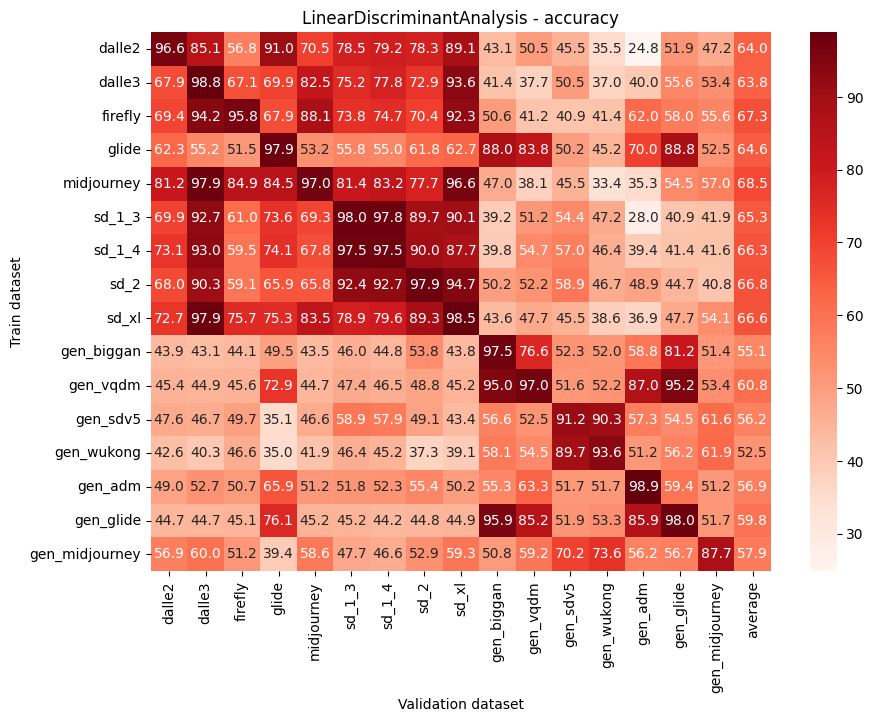

val_dataset       dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.984375  0.794792  0.584375  0.904167    0.719792  0.625000   
dalle3          0.633333  0.989583  0.710417  0.529167    0.768750  0.798958   
firefly         0.654167  0.942708  0.952083  0.526042    0.783333  0.789583   
glide           0.627083  0.564583  0.555208  0.975000    0.588542  0.496875   
midjourney      0.857292  0.966667  0.847917  0.776042    0.958333  0.800000   
sd_1_3          0.581250  0.861458  0.708333  0.528125    0.683333  0.978125   
sd_1_4          0.591667  0.880208  0.726042  0.531250    0.687500  0.982292   
sd_2            0.527083  0.753125  0.608333  0.491667    0.535417  0.798958   
sd_xl           0.620833  0.939583  0.800000  0.557292    0.746875  0.746875   
gen_biggan      0.547917  0.518750  0.528125  0.868750    0.538542  0.466667   
gen_vqdm        0.504167  0.497917  0.503125  0.792708    0.491667  0.506250   
gen_sdv5        0.415625  0.462500  0.455208  0.240625    0.443750  0.559375   
gen_wukong      0.367708  0.400000  0.456250  0.198958    0.408333  0.503125   
gen_adm         0.525000  0.483333  0.523958  0.626042    0.500000  0.496875   
gen_glide       0.530208  0.517708  0.526042  0.860417    0.527083  0.489583   
gen_midjourney  0.513542  0.456250  0.458333  0.276042    0.557292  0.334375   

val_dataset       sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.637500  0.680208  0.822917    0.384375  0.401562  0.464062   
dalle3          0.808333  0.728125  0.847917    0.406250  0.381250  0.551562   
firefly         0.802083  0.769792  0.919792    0.485938  0.360938  0.485938   
glide           0.498958  0.507292  0.566667    0.984375  0.668750  0.507812   
midjourney      0.807292  0.705208  0.950000    0.512500  0.256250  0.565625   
sd_1_3          0.971875  0.933333  0.833333    0.403125  0.487500  0.656250   
sd_1_4          0.976042  0.950000  0.842708    0.434375  0.517188  0.651563   
sd_2            0.814583  0.975000  0.841667    0.518750  0.545312  0.543750   
sd_xl           0.782292  0.914583  0.976042    0.523438  0.342187  0.504687   
gen_biggan      0.470833  0.460417  0.523958    0.998437  0.592187  0.514062   
gen_vqdm        0.506250  0.506250  0.500000    0.739062  0.995313  0.507812   
gen_sdv5        0.557292  0.498958  0.405208    0.484375  0.465625  0.932813   
gen_wukong      0.487500  0.360417  0.350000    0.501563  0.487500  0.885938   
gen_adm         0.503125  0.487500  0.503125    0.532813  0.554688  0.509375   
gen_glide       0.484375  0.466667  0.520833    0.998437  0.646875  0.514062   
gen_midjourney  0.333333  0.305208  0.464583    0.470313  0.478125  0.601562   

val_dataset     gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2            0.317188  0.381250   0.479687        0.492188  0.604590  
dalle3            0.467187  0.417187   0.390625        0.470313  0.618685  
firefly           0.459375  0.500000   0.406250        0.442188  0.642513  
glide             0.501563  0.645312   0.982812        0.509375  0.636263  
midjourney        0.446875  0.293750   0.453125        0.537500  0.670898  
sd_1_3            0.568750  0.468750   0.337500        0.398438  0.649967  
sd_1_4            0.570312  0.450000   0.329688        0.390625  0.656966  
sd_2              0.440625  0.425000   0.390625        0.393750  0.600228  
sd_xl             0.368750  0.395313   0.382812        0.451562  0.628320  
gen_biggan        0.514062  0.525000   0.984375        0.514062  0.597884  
gen_vqdm          0.509375  0.964063   0.890625        0.514062  0.620540  
gen_sdv5          0.943750  0.465625   0.482812        0.523438  0.521061  
gen_wukong        0.959375  0.495312   0.493750       

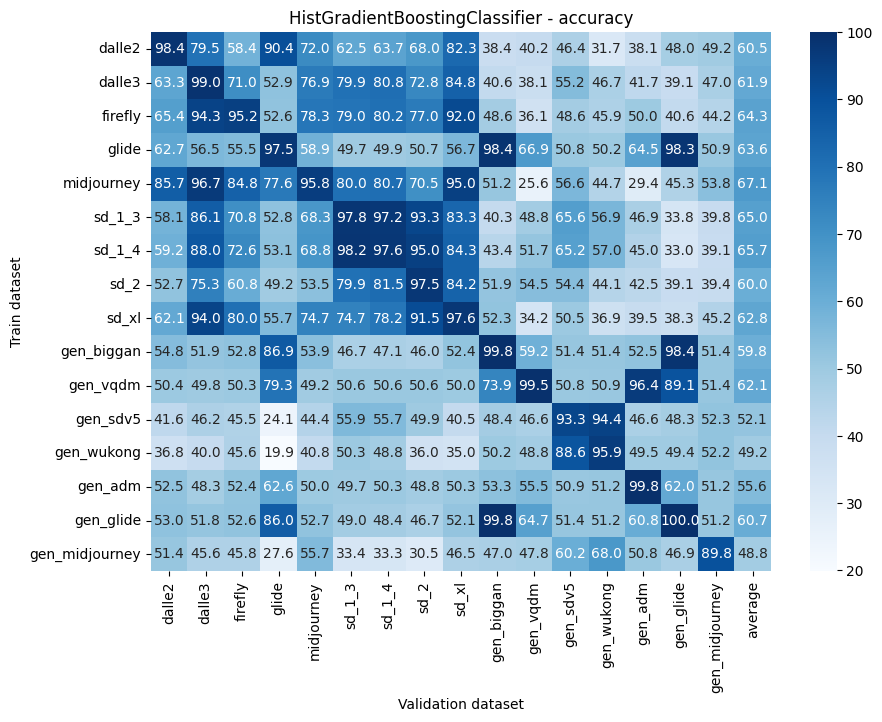

val_dataset       dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.958333  0.770833  0.581250  0.912500    0.754167  0.530208   
dalle3          0.595833  0.966667  0.722917  0.527083    0.755208  0.764583   
firefly         0.604167  0.945833  0.937500  0.521875    0.768750  0.802083   
glide           0.598958  0.537500  0.541667  0.946875    0.580208  0.470833   
midjourney      0.779167  0.936458  0.814583  0.741667    0.909375  0.760417   
sd_1_3          0.570833  0.866667  0.745833  0.520833    0.708333  0.967708   
sd_1_4          0.563542  0.877083  0.758333  0.510417    0.706250  0.969792   
sd_2            0.498958  0.705208  0.638542  0.485417    0.531250  0.780208   
sd_xl           0.573958  0.897917  0.805208  0.513542    0.696875  0.707292   
gen_biggan      0.558333  0.517708  0.537500  0.883333    0.551042  0.466667   
gen_vqdm        0.504167  0.504167  0.504167  0.829167    0.503125  0.504167   
gen_sdv5        0.478125  0.585417  0.554167  0.311458    0.521875  0.633333   
gen_wukong      0.382292  0.457292  0.463542  0.212500    0.401042  0.520833   
gen_adm         0.509375  0.508333  0.508333  0.840625    0.508333  0.505208   
gen_glide       0.526042  0.515625  0.522917  0.859375    0.522917  0.482292   
gen_midjourney  0.567708  0.438542  0.475000  0.386458    0.575000  0.381250   

val_dataset       sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.535417  0.556250  0.761458    0.395313  0.373437  0.448437   
dalle3          0.764583  0.665625  0.809375    0.420312  0.407813  0.579688   
firefly         0.807292  0.705208  0.919792    0.471875  0.389062  0.543750   
glide           0.465625  0.469792  0.538542    0.964063  0.620313  0.507812   
midjourney      0.756250  0.592708  0.910417    0.468750  0.365625  0.554688   
sd_1_3          0.957292  0.905208  0.821875    0.414062  0.429688  0.645312   
sd_1_4          0.962500  0.920833  0.835417    0.412500  0.415625  0.657813   
sd_2            0.768750  0.964583  0.784375    0.501563  0.509375  0.534375   
sd_xl           0.725000  0.805208  0.952083    0.509375  0.437500  0.485938   
gen_biggan      0.477083  0.451042  0.523958    0.998437  0.639062  0.514062   
gen_vqdm        0.503125  0.504167  0.502083    0.976562  0.987500  0.506250   
gen_sdv5        0.627083  0.544792  0.490625    0.465625  0.448437  0.889062   
gen_wukong      0.508333  0.401042  0.345833    0.484375  0.459375  0.850000   
gen_adm         0.507292  0.503125  0.508333    0.981250  0.932813  0.507812   
gen_glide       0.478125  0.448958  0.520833    0.996875  0.690625  0.510938   
gen_midjourney  0.383333  0.375000  0.454167    0.431250  0.445312  0.506250   

val_dataset     gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2            0.331250  0.446875   0.528125        0.537500  0.588835  
dalle3            0.495312  0.462500   0.417187        0.487500  0.615137  
firefly           0.500000  0.510938   0.423438        0.460938  0.644531  
glide             0.509375  0.615625   0.976562        0.518750  0.616406  
midjourney        0.459375  0.414062   0.454688        0.514062  0.652018  
sd_1_3            0.575000  0.437500   0.379688        0.426563  0.648275  
sd_1_4            0.582812  0.418750   0.354687        0.425000  0.648210  
sd_2              0.445312  0.420312   0.420312        0.414062  0.587663  
sd_xl             0.384375  0.506250   0.400000        0.445312  0.615365  
gen_biggan        0.514062  0.531250   0.989062        0.512500  0.604069  
gen_vqdm          0.504687  0.975000   0.987500        0.509375  0.644076  
gen_sdv5          0.917188  0.454688   0.445312        0.498437  0.554102  
gen_wukong        0.937500  0.470313   0.476562       

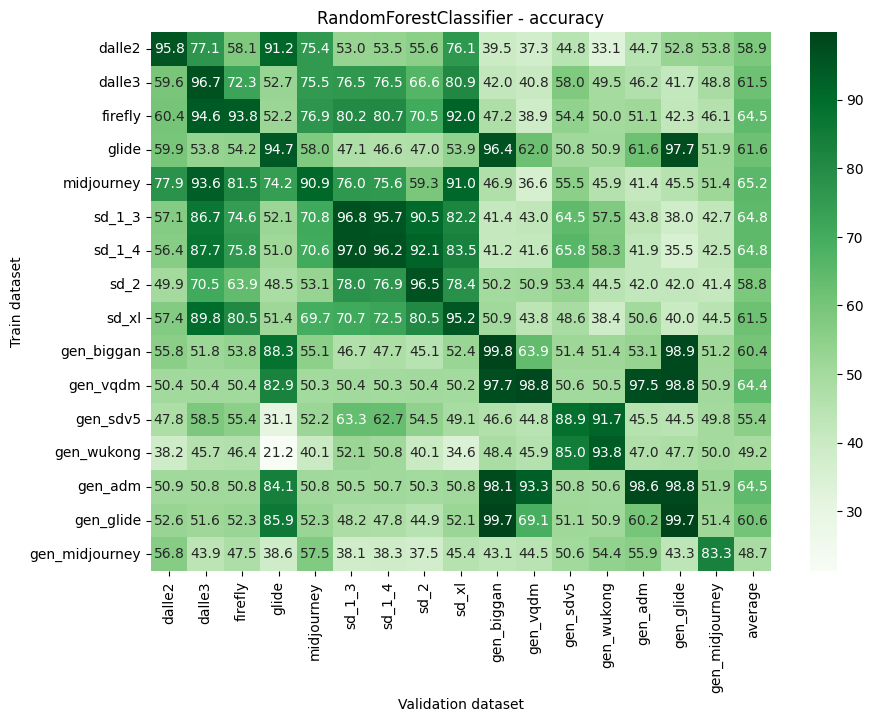

val_dataset       dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.967708  0.909375  0.658333  0.909375    0.822917  0.765625   
dalle3          0.616667  0.994792  0.752083  0.563542    0.788542  0.740625   
firefly         0.627083  0.955208  0.965625  0.577083    0.858333  0.719792   
glide           0.610417  0.557292  0.546875  0.977083    0.573958  0.551042   
midjourney      0.761458  0.970833  0.900000  0.758333    0.963542  0.750000   
sd_1_3          0.616667  0.906250  0.680208  0.558333    0.687500  0.980208   
sd_1_4          0.607292  0.897917  0.655208  0.548958    0.646875  0.975000   
sd_2            0.546875  0.802083  0.577083  0.536458    0.547917  0.831250   
sd_xl           0.630208  0.958333  0.822917  0.563542    0.781250  0.706250   
gen_biggan      0.522917  0.507292  0.521875  0.812500    0.535417  0.490625   
gen_vqdm        0.505208  0.505208  0.505208  0.833333    0.501042  0.505208   
gen_sdv5        0.528125  0.517708  0.478125  0.350000    0.490625  0.616667   
gen_wukong      0.478125  0.397917  0.453125  0.320833    0.390625  0.517708   
gen_adm         0.509375  0.509375  0.509375  0.830208    0.507292  0.509375   
gen_glide       0.520833  0.518750  0.519792  0.854167    0.520833  0.510417   
gen_midjourney  0.633333  0.617708  0.548958  0.391667    0.630208  0.488542   

val_dataset       sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.765625  0.750000  0.907292    0.243750  0.518750  0.496875   
dalle3          0.765625  0.663542  0.909375    0.446875  0.446875  0.535937   
firefly         0.732292  0.664583  0.942708    0.403125  0.375000  0.439063   
glide           0.532292  0.568750  0.579167    0.976562  0.731250  0.506250   
midjourney      0.761458  0.641667  0.966667    0.371875  0.362500  0.428125   
sd_1_3          0.978125  0.927083  0.860417    0.298438  0.484375  0.673438   
sd_1_4          0.977083  0.922917  0.842708    0.301563  0.535937  0.625000   
sd_2            0.848958  0.976042  0.859375    0.603125  0.626563  0.584375   
sd_xl           0.733333  0.753125  0.986458    0.431250  0.484375  0.476562   
gen_biggan      0.488542  0.515625  0.541667    0.998437  0.589063  0.514062   
gen_vqdm        0.505208  0.505208  0.504167    0.990625  0.995313  0.509375   
gen_sdv5        0.616667  0.497917  0.489583    0.501563  0.485938  0.942187   
gen_wukong      0.526042  0.400000  0.408333    0.503125  0.496875  0.928125   
gen_adm         0.509375  0.509375  0.509375    0.937500  0.853125  0.510938   
gen_glide       0.507292  0.512500  0.520833    0.993750  0.737500  0.509375   
gen_midjourney  0.488542  0.467708  0.605208    0.489063  0.485938  0.679688   

val_dataset     gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2            0.420312  0.403125   0.512500        0.509375  0.660059  
dalle3            0.485938  0.429688   0.459375        0.525000  0.632780  
firefly           0.385937  0.692187   0.417187        0.498437  0.640853  
glide             0.506250  0.784375   0.976562        0.514062  0.655762  
midjourney        0.359375  0.528125   0.450000        0.614062  0.661751  
sd_1_3            0.570312  0.412500   0.290625        0.393750  0.644889  
sd_1_4            0.540625  0.412500   0.264062        0.367188  0.632552  
sd_2              0.465625  0.484375   0.448437        0.421875  0.635026  
sd_xl             0.451562  0.714063   0.443750        0.528125  0.654069  
gen_biggan        0.512500  0.523438   0.929688        0.514062  0.594857  
gen_vqdm          0.510938  0.935937   0.993750        0.512500  0.644889  
gen_sdv5          0.960938  0.498437   0.501563        0.575000  0.565690  
gen_wukong        0.964063  0.504687   0.496875       

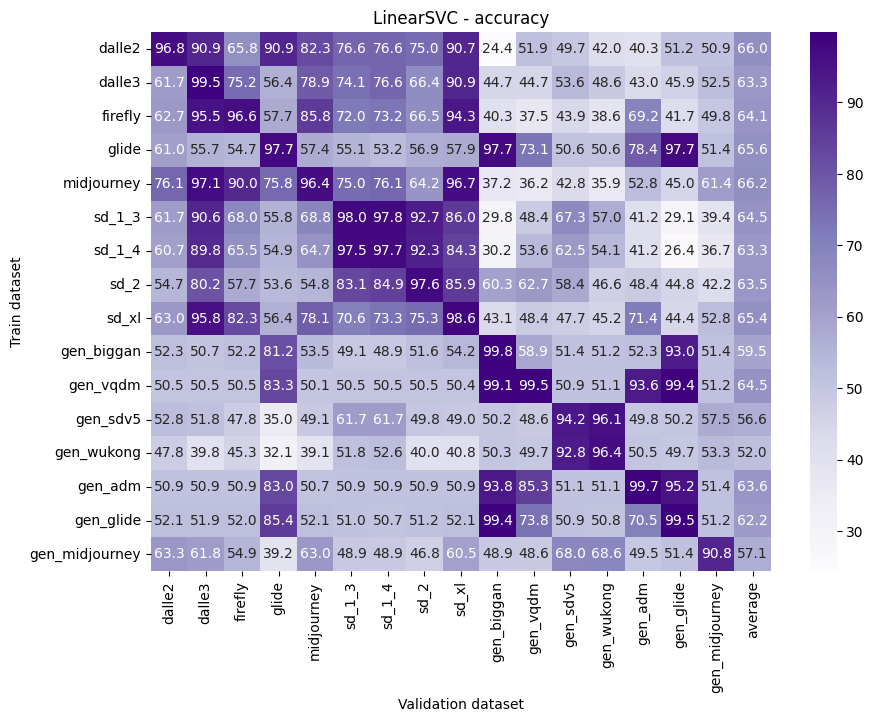

In [21]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="val_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

metric = "accuracy"
evaluation_data_name = "Validation"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

val_dataset       dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.931387  0.718832  0.224949  0.824475    0.477741  0.608927   
dalle3          0.448476  0.975293  0.434738  0.480672    0.682458  0.565473   
firefly         0.448342  0.883317  0.917261  0.423517    0.768040  0.521606   
glide           0.352386  0.207305  0.096890  0.958356    0.154756  0.222241   
midjourney      0.655450  0.958983  0.716646  0.709557    0.939725  0.657175   
sd_1_3          0.476030  0.857272  0.323440  0.536567    0.465824  0.960652   
sd_1_4          0.520458  0.861654  0.282018  0.535758    0.432620  0.950638   
sd_2            0.450184  0.815004  0.291492  0.415625    0.413873  0.852531   
sd_xl           0.525731  0.958356  0.573746  0.567127    0.699551  0.623541   
gen_biggan     -0.211885 -0.250424 -0.201610 -0.001806   -0.227883 -0.116285   
gen_vqdm       -0.091068 -0.101823 -0.086783  0.483175   -0.106142 -0.050705   
gen_sdv5       -0.046424 -0.065495 -0.004550 -0.324250   -0.067624  0.176719   
gen_wukong     -0.148797 -0.197496 -0.067673 -0.318066   -0.164126 -0.071872   
gen_adm        -0.016699  0.074024  0.027693  0.337840    0.040187  0.052457   
gen_glide      -0.106142 -0.106142 -0.097513  0.566755   -0.095362 -0.095362   
gen_midjourney  0.137205  0.199711  0.026135 -0.220144    0.172483 -0.044441   

val_dataset       sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.619204  0.605507  0.788374   -0.154853  0.040124 -0.106044   
dalle3          0.606897  0.529049  0.875620   -0.179639 -0.280729  0.007116   
firefly         0.537202  0.465914  0.846344    0.009825 -0.198438 -0.196916   
glide           0.202178  0.342948  0.359850    0.766330  0.675182 -0.018181   
midjourney      0.688447  0.597357  0.931281   -0.054989 -0.238063 -0.087081   
sd_1_3          0.956401  0.802394  0.809823   -0.220902  0.045320  0.133059   
sd_1_4          0.950638  0.805349  0.764219   -0.203116  0.125640  0.188121   
sd_2            0.858260  0.958356  0.895224    0.010295  0.053998  0.194496   
sd_xl           0.635233  0.796646  0.971032   -0.134858 -0.061967 -0.095699   
gen_biggan     -0.167816  0.109393 -0.217137    0.949970  0.585729  0.056786   
gen_vqdm       -0.069732 -0.023468 -0.095362    0.901516  0.940635  0.015748   
gen_sdv5        0.158083 -0.017049 -0.132681    0.155739  0.044039  0.825867   
gen_wukong     -0.095087 -0.264481 -0.224778    0.217010  0.113587  0.793576   
gen_adm         0.064517  0.133188  0.014958    0.183270  0.366222  0.026937   
gen_glide      -0.116988 -0.103981 -0.101823    0.920718  0.731232  0.037293   
gen_midjourney -0.067610  0.059037  0.185018   -0.006922  0.208466  0.420874   

val_dataset     gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2           -0.318361 -0.523563   0.100891       -0.051966  0.299101  
dalle3           -0.275900 -0.211112   0.112998        0.072517  0.302745  
firefly          -0.192748  0.253002   0.158938        0.112457  0.359854  
glide            -0.158570  0.405772   0.783082        0.041393  0.336995  
midjourney       -0.333066 -0.293321   0.101974        0.176833  0.382932  
sd_1_3           -0.049190 -0.440739  -0.182176       -0.161095  0.332043  
sd_1_4           -0.066362 -0.214398  -0.171232       -0.167041  0.349685  
sd_2             -0.062016 -0.015337  -0.103363       -0.183802  0.365301  
sd_xl            -0.266394 -0.286930  -0.054888        0.081917  0.345759  
gen_biggan        0.042605  0.270753   0.660706        0.003166  0.080266  
gen_vqdm          0.056019  0.760191   0.904186        0.114604  0.221937  
gen_sdv5          0.808014  0.192050   0.117782        0.268755  0.130561  
gen_wukong        0.872640 -0.000933   0.176468       

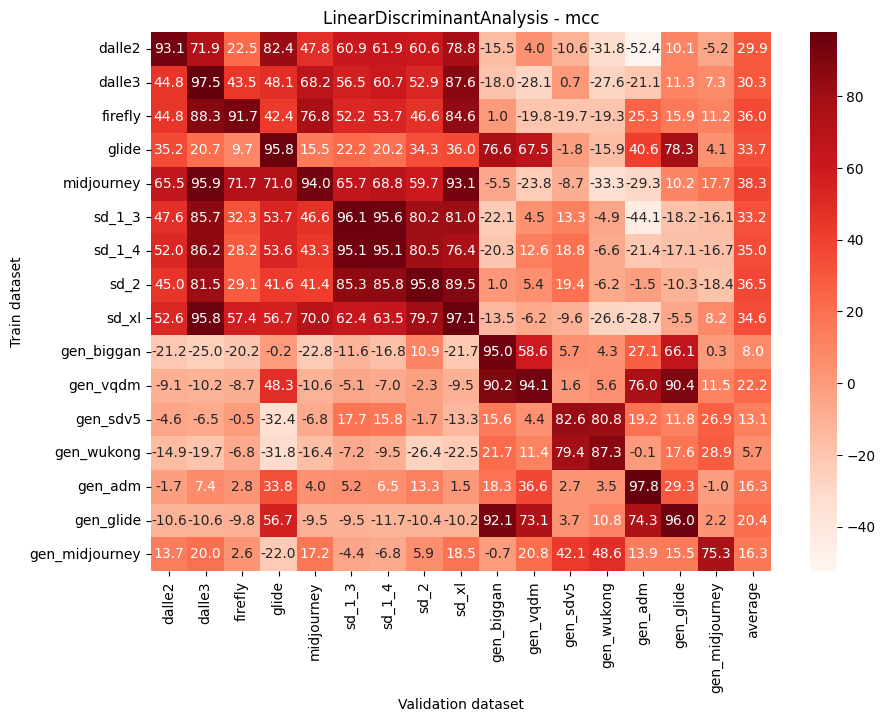

val_dataset       dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.968843  0.634670  0.281203  0.817361    0.515592  0.358156   
dalle3          0.381235  0.979195  0.507060  0.159648    0.598369  0.645877   
firefly         0.384249  0.885425  0.904207  0.111064    0.600702  0.611110   
glide           0.346882  0.221623  0.199745  0.950379    0.273033  0.012816   
midjourney      0.730253  0.933439  0.714162  0.594601    0.916654  0.633883   
sd_1_3          0.263846  0.740087  0.489809  0.133461    0.448847  0.956482   
sd_1_4          0.289239  0.773681  0.521225  0.147005    0.458859  0.964821   
sd_2            0.134489  0.564549  0.321504 -0.014921    0.158975  0.638131   
sd_xl           0.350681  0.881741  0.643014  0.222267    0.558552  0.558552   
gen_biggan      0.114618  0.051559  0.072305  0.747412    0.094806 -0.075400   
gen_vqdm        0.013412  0.000278  0.011232  0.599365   -0.012989  0.017762   
gen_sdv5       -0.168718 -0.074474 -0.088969 -0.589485   -0.111844  0.118190   
gen_wukong     -0.264396 -0.199918 -0.089295 -0.654678   -0.183458  0.003853   
gen_adm         0.109306 -0.054739  0.106190  0.335226    0.023558  0.010662   
gen_glide       0.070702  0.044468  0.062020  0.746223    0.064196 -0.016961   
gen_midjourney  0.028319 -0.086783 -0.082507 -0.534173    0.114619 -0.364261   

val_dataset       sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.380161  0.451886  0.680020   -0.271586 -0.220954 -0.082324   
dalle3          0.660749  0.534866  0.724579   -0.254717 -0.311123  0.099458   
firefly         0.632020  0.578231  0.840803   -0.027441 -0.290279 -0.027441   
glide           0.022475  0.057421  0.226330    0.968912  0.416237 -0.077105   
midjourney      0.645928  0.479093  0.900130    0.045320 -0.486881  0.201035   
sd_1_3          0.943785  0.868687  0.692642   -0.207713 -0.029462  0.328364   
sd_1_4          0.952121  0.900818  0.709930   -0.138529  0.033023  0.320455   
sd_2            0.663529  0.950020  0.708193    0.031938  0.086208  0.083209   
sd_xl           0.614720  0.835945  0.952079    0.050593 -0.338114  0.012254   
gen_biggan     -0.064313 -0.092418  0.063146    0.996877  0.289729  0.000000   
gen_vqdm        0.017762  0.017762  0.004671    0.540237  0.990664 -0.077105   
gen_sdv5        0.113963 -0.002371 -0.190134   -0.170064 -0.219358  0.865683   
gen_wukong     -0.027470 -0.279165 -0.300437   -0.109388 -0.160606  0.776197   
gen_adm         0.035839 -0.032629  0.035839    0.124649  0.204715 -0.066723   
gen_glide      -0.028774 -0.070183  0.051080    0.996878  0.391893  0.000000   
gen_midjourney -0.366992 -0.444447 -0.069732   -0.194363 -0.179891  0.235267   

val_dataset     gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2           -0.403212 -0.278034  -0.029991        0.015107  0.238556  
dalle3           -0.083042 -0.219542  -0.286377       -0.079284  0.253559  
firefly          -0.083736 -0.000616  -0.198306       -0.119860  0.300008  
glide            -0.109388  0.389083   0.965631       -0.042127  0.301372  
midjourney       -0.103754 -0.412458  -0.090351        0.111889  0.363309  
sd_1_3            0.139702 -0.070810  -0.383825       -0.226691  0.317951  
sd_1_4            0.144217 -0.108006  -0.392640       -0.239984  0.333515  
sd_2             -0.157397 -0.185259  -0.315755       -0.302630  0.210299  
sd_xl            -0.270546 -0.218611  -0.256086       -0.102291  0.280922  
gen_biggan        0.000000  0.108160   0.969173        0.000000  0.204728  
gen_vqdm         -0.066723  0.929596   0.795135        0.001575  0.236415  
gen_sdv5          0.887411 -0.219358  -0.174623        0.041226  0.001067  
gen_wukong        0.918686 -0.134398  -0.139997       

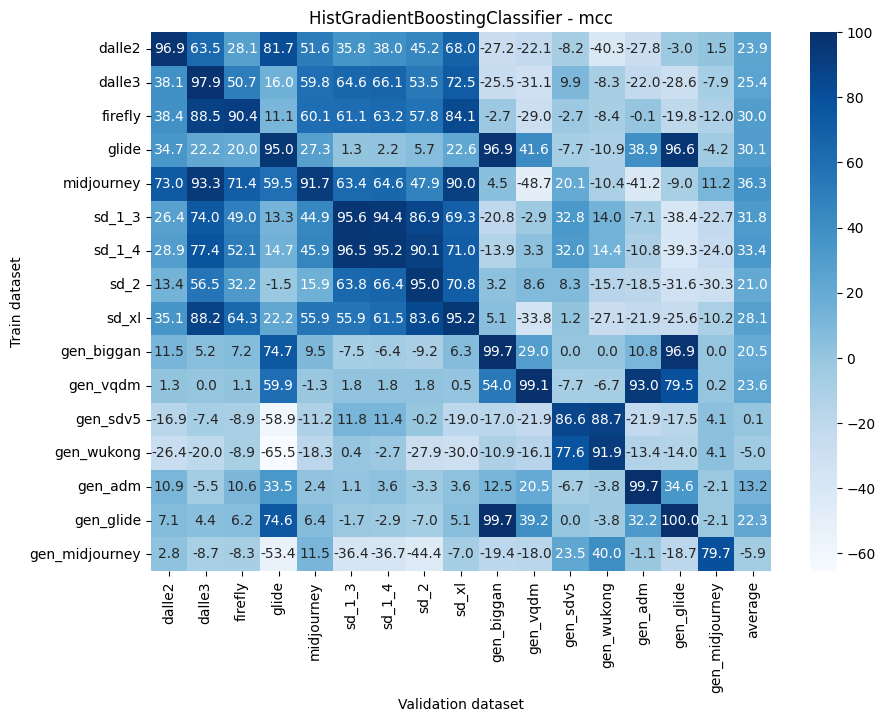

val_dataset       dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.916764  0.581940  0.249112  0.827463    0.554520  0.125891   
dalle3          0.299586  0.933406  0.517639  0.136746    0.569147  0.584092   
firefly         0.292251  0.891650  0.875128  0.098609    0.576507  0.632020   
glide           0.262971  0.126596  0.137054  0.895292    0.224644 -0.099362   
midjourney      0.590141  0.872902  0.650077  0.527500    0.820146  0.558771   
sd_1_3          0.241567  0.749019  0.550328  0.110512    0.489809  0.935407   
sd_1_4          0.221194  0.765866  0.568053  0.070648    0.483569  0.939663   
sd_2            0.023120  0.481864  0.369153 -0.051693    0.138825  0.603505   
sd_xl           0.233519  0.800411  0.638946  0.074259    0.459926  0.477272   
gen_biggan      0.136951  0.049646  0.093194  0.779985    0.121847 -0.075922   
gen_vqdm        0.013259  0.013259  0.013259  0.689932    0.011086  0.013259   
gen_sdv5       -0.041936  0.172603  0.111478 -0.478094    0.047543  0.266593   
gen_wukong     -0.235342 -0.086191 -0.073884 -0.633412   -0.197538  0.040079   
gen_adm         0.024449  0.022280  0.022280  0.715603    0.022280  0.015751   
gen_glide       0.061329  0.039488  0.054816  0.747202    0.054816 -0.033440   
gen_midjourney  0.151311 -0.148909 -0.051974 -0.323677    0.165822 -0.344920   

val_dataset       sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.140438  0.193362  0.566507   -0.230455 -0.262310 -0.105636   
dalle3          0.584092  0.424334  0.656038   -0.228473 -0.251662  0.158150   
firefly         0.640774  0.471294  0.840803   -0.063841 -0.256399  0.085087   
glide          -0.126178 -0.104527  0.129233    0.928549  0.322742 -0.077105   
midjourney      0.551818  0.263478  0.822132   -0.056416 -0.267421  0.144218   
sd_1_3          0.914751  0.816855  0.673640   -0.198342 -0.167172  0.292786   
sd_1_4          0.924988  0.844740  0.694492   -0.196398 -0.189110  0.319796   
sd_2            0.584914  0.929160  0.610281   -0.010913  0.002447  0.062759   
sd_xl           0.506556  0.638946  0.904155    0.016610 -0.138333 -0.033796   
gen_biggan     -0.048300 -0.119934  0.063637    0.996877  0.377741  0.000000   
gen_vqdm        0.011086  0.013259  0.008909    0.953097  0.975065 -0.086274   
gen_sdv5        0.254241  0.093034 -0.015911   -0.219358 -0.257666  0.778845   
gen_wukong      0.014919 -0.197538 -0.310790   -0.170064 -0.233851  0.704802   
gen_adm         0.020107  0.011381  0.022280    0.962620  0.870969 -0.077105   
gen_glide      -0.042948 -0.112663  0.050456    0.993766  0.464687 -0.054436   
gen_midjourney -0.336311 -0.371703 -0.105566   -0.260982 -0.207645 -0.006375   

val_dataset     gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2           -0.344827 -0.109243   0.108155        0.152172  0.210241  
dalle3           -0.023844 -0.106554  -0.236535       -0.044544  0.248226  
firefly          -0.003996  0.016750  -0.176626       -0.087337  0.302042  
glide            -0.066723  0.337380   0.953184        0.043185  0.242933  
midjourney       -0.076403 -0.169707  -0.086604        0.043958  0.324287  
sd_1_3            0.149180 -0.149039  -0.310290       -0.179547  0.307466  
sd_1_4            0.167081 -0.186395  -0.362714       -0.181794  0.305230  
sd_2             -0.163980 -0.230222  -0.266809       -0.288529  0.174618  
sd_xl            -0.251713  0.007955  -0.233771       -0.125368  0.248473  
gen_biggan        0.000000  0.136016   0.978329       -0.038462  0.215725  
gen_vqdm         -0.094583  0.949960   0.974980       -0.042127  0.276089  
gen_sdv5          0.834546 -0.244273  -0.264171       -0.044577  0.062056  
gen_wukong        0.874901 -0.207963  -0.191910       

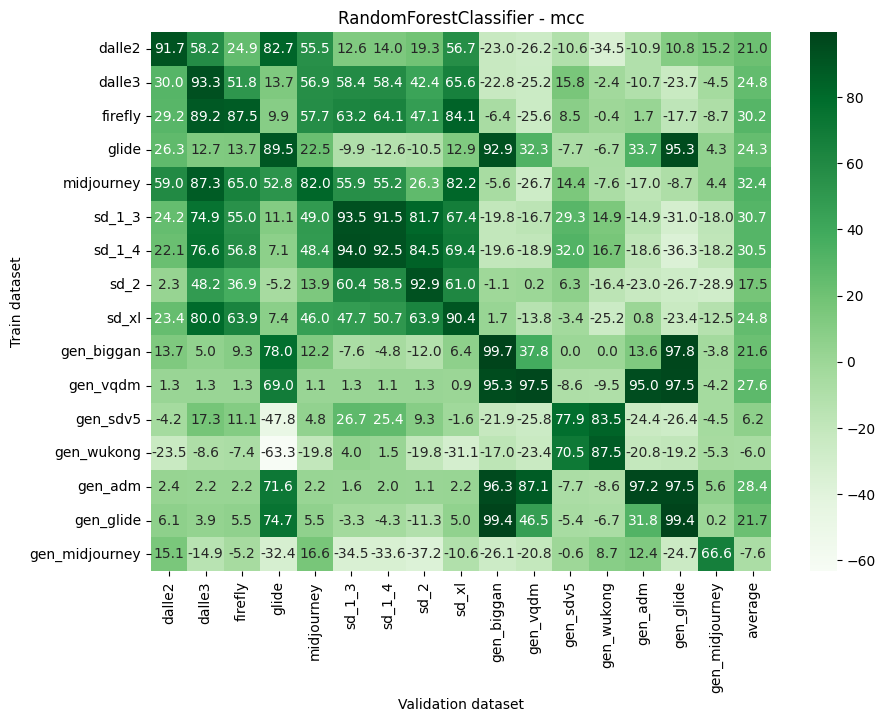

val_dataset       dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.935518  0.826144  0.413873  0.826144    0.679055  0.586991   
dalle3          0.361709  0.989584  0.578190  0.259735    0.634499  0.560554   
firefly         0.359850  0.911161  0.931419  0.263788    0.737696  0.514102   
glide           0.317768  0.206658  0.181124  0.954549    0.244345  0.191553   
midjourney      0.568638  0.942157  0.804965  0.563526    0.927218  0.549902   
sd_1_3          0.345259  0.821566  0.453618  0.227264    0.465450  0.960412   
sd_1_4          0.317543  0.804247  0.403274  0.192613    0.388953  0.950059   
sd_2            0.191913  0.644231  0.261510  0.164207    0.194552  0.691792   
sd_xl           0.369436  0.917493  0.681002  0.239186    0.614259  0.495563   
gen_biggan      0.108683  0.055192  0.105423  0.653690    0.145267 -0.018403   
gen_vqdm        0.015509  0.015509  0.015509  0.699697    0.006795  0.015509   
gen_sdv5        0.064164  0.042673 -0.042556 -0.403448   -0.014937  0.238337   
gen_wukong     -0.042004 -0.228552 -0.096512 -0.462991   -0.247637  0.040057   
gen_adm         0.024544  0.024544  0.024544  0.687984    0.020195  0.024544   
gen_glide       0.049716  0.045374  0.047547  0.738662    0.049716  0.027855   
gen_midjourney  0.281776  0.252170  0.116120 -0.322562    0.275878 -0.019224   

val_dataset       sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.586991  0.562164  0.822420   -0.522600  0.070925  0.017453   
dalle3          0.599050  0.440073  0.830974   -0.196200 -0.206939  0.067127   
firefly         0.534023  0.424348  0.887341   -0.225069 -0.291230 -0.142329   
glide           0.141830  0.232924  0.255486    0.953142  0.525191 -0.072185   
midjourney      0.568638  0.368151  0.933594   -0.272992 -0.307635 -0.151593   
sd_1_3          0.956246  0.858996  0.742747   -0.439754 -0.032066  0.386966   
sd_1_4          0.954283  0.849556  0.709118   -0.420047  0.075781  0.284642   
sd_2            0.721183  0.952091  0.738696    0.204688  0.251854  0.167041   
sd_xl           0.538544  0.569788  0.973011   -0.179486 -0.062890 -0.073544   
gen_biggan     -0.029561  0.085033  0.162099    0.996878  0.282981  0.000000   
gen_vqdm        0.015509  0.015509  0.013336    0.981251  0.990623 -0.066723   
gen_sdv5        0.238337  0.000851 -0.017211   -0.066817 -0.142544  0.884278   
gen_wukong      0.056849 -0.223184 -0.202065   -0.089565 -0.128574  0.857568   
gen_adm         0.024544  0.024544  0.024544    0.880766  0.732463 -0.054436   
gen_glide       0.021221  0.032258  0.049716    0.987512  0.542095 -0.066723   
gen_midjourney -0.019224 -0.072137  0.228241   -0.131965 -0.136729  0.389593   

val_dataset     gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2           -0.164748 -0.208583   0.056045        0.049038  0.346052  
dalle3           -0.064618 -0.260585  -0.142132        0.041367  0.280774  
firefly          -0.262263  0.398200  -0.197950       -0.008364  0.302170  
glide            -0.051352  0.611001   0.953097        0.005309  0.353153  
midjourney       -0.310393  0.055839  -0.105593        0.240718  0.335946  
sd_1_3            0.146244 -0.177551  -0.478652       -0.223918  0.313302  
sd_1_4            0.085347 -0.174651  -0.520604       -0.275391  0.289045  
sd_2             -0.090935 -0.045579  -0.138570       -0.228840  0.292490  
sd_xl            -0.157092  0.427371  -0.160063        0.048744  0.327583  
gen_biggan       -0.038462  0.100057   0.865955        0.000000  0.217177  
gen_vqdm         -0.054436  0.876678   0.987490       -0.038462  0.280581  
gen_sdv5          0.921811 -0.122493  -0.088302        0.216735  0.106805  
gen_wukong        0.928150 -0.094583  -0.128574       

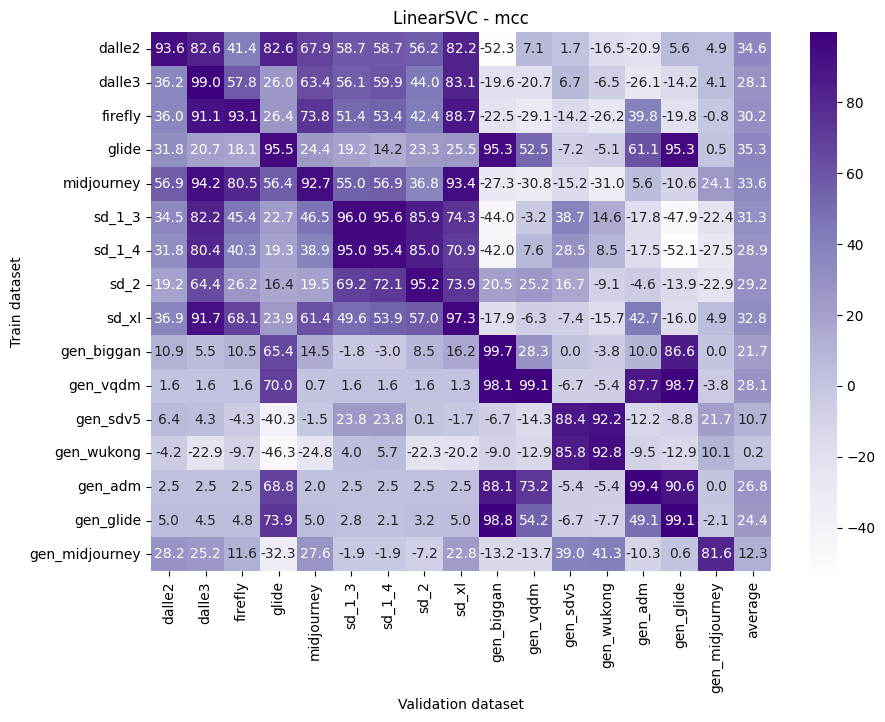

In [22]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "mcc"
evaluation_data_name = "Validation"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

### Test data

In [23]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for test_dataset_name in X_test.keys():
        print(f"\n\nValidation set: {test_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print() 
            # leave only the columns that are in the training set
            X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, test_dataset_name, model_name)] = model_results
            





 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9752
Recall: 0.9750
MCC: 0.9502

Model: LinearDiscriminantAnalysis
Accuracy: 0.9700
F1: 0.9700
Precision: 0.9705
Recall: 0.9700
MCC: 0.9405

Model: RandomForestClassifier
Accuracy: 0.9533
F1: 0.9533
Precision: 0.9536
Recall: 0.9533
MCC: 0.9069

Model: LinearSVC
Accuracy: 0.9533
F1: 0.9533
Precision: 0.9533
Recall: 0.9533
MCC: 0.9066


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.7817
F1: 0.7750
Precision: 0.8255
Recall: 0.7817
MCC: 0.6070

Model: LinearDiscriminantAnalysis
Accuracy: 0.8400
F1: 0.8383
Precision: 0.8590
Recall: 0.8400
MCC: 0.6993

Model: RandomForestClassifier
Accuracy: 0.7583
F1: 0.7510
Precision: 0.7989
Recall: 0.7583
MCC: 0.5573

Model: LinearSVC
Accuracy: 0.9033
F1: 0.9032
Precision: 0.9070
Recall: 0.9033
MCC: 0.8105


Validation set: firefly

Model: HistGradientBoostingClassifier
Accur

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3785
Precision: 0.5651
Recall: 0.5100
MCC: 0.0510



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354


Validation set: gen_wukong



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5062
F1: 0.3614
Precision: 0.5674
Recall: 0.5062
MCC: 0.0410

Model: RandomForestClassifier
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: gen_adm



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5875
F1: 0.5078
Precision: 0.7486
Recall: 0.5875
MCC: 0.2950

Model: RandomForestClassifier
Accuracy: 0.5100
F1: 0.3552
Precision: 0.7525
Recall: 0.5100
MCC: 0.1005

Model: LinearSVC
Accuracy: 0.5062
F1: 0.3492
Precision: 0.6801
Recall: 0.5062
MCC: 0.0671


Validation set: gen_glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9888
F1: 0.9887
Precision: 0.9890
Recall: 0.9888
MCC: 0.9777

Model: LinearDiscriminantAnalysis
Accuracy: 0.7987
F1: 0.7921
Precision: 0.8425
Recall: 0.7987
MCC: 0.6398

Model: RandomForestClassifier
Accuracy: 0.9912
F1: 0.9912
Precision: 0.9913
Recall: 0.9912
MCC: 0.9826

Model: LinearSVC
Accuracy: 0.9463
F1: 0.9461
Precision: 0.9515
Recall: 0.9463
MCC: 0.8977


Validation set: gen_midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5075
F1: 0.3620
Precision: 0.5853
Recall: 0.5075
MCC: 0.0506

Model: RandomForestClassifier
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354

Model: LinearSVC
Accuracy: 0.4963
F1: 0.3317
Precision: 0.2491
Recall: 0.4963
MCC: -0.0614




 *** Evaluating models trained on gen_vqdm. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.4892
F1: 0.4708
Precision: 0.4915
Recall: 0.4892
MCC: -0.0160

Model: LinearDiscriminantAnalysis
Accuracy: 0.4358
F1: 0.4279
Precision: 0.4342
Recall: 0.4358
MCC: -0.1276

Model: RandomForestClassifier
Accuracy: 0.4825
F1: 0.4656
Precision: 0.4838
Recall: 0.4825
MCC: -0.0305

Model: LinearSVC
Accuracy: 0.4825
F1: 0.4656
Precision: 0.4838
Recall: 0.4825
MCC: -0.0305


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.4875
F1: 0.4

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3453
Precision: 0.5631
Recall: 0.5025
MCC: 0.0251

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: gen_wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.4963
F1: 0.3317
Precision: 0.2491
Recall: 0.4963
MCC: -0.0614

Model: LinearDiscriminantAnalysis
Accuracy: 0.4963
F1: 0.3360
Precision: 0.3919
Recall: 0.4963
MCC: -0.0403

Model: RandomForestClassifier
Accuracy: 0.4938
F1: 0.3305
Precision: 0.2484
Recall: 0.4938
MCC: -0.0793

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: gen_adm

Model: HistGradientBoostingClassifier
Accuracy: 0.9988
F1: 0.9987
Precision: 0.9988
Recall: 0.9988
MCC: 0.997

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3548
Precision: 0.5727
Recall: 0.5050
MCC: 0.0381



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354


Validation set: gen_wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709

Model: LinearDiscriminantAnalysis
Accuracy: 0.5162
F1: 0.3800
Precision: 0.6342
Recall: 0.5162
MCC: 0.0934

Model: RandomForestClassifier
Accuracy: 0.4963
F1: 0.3317
Precision: 0.2491
Recall: 0.4963
MCC: -0.0614

Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: gen_adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5925
F1: 0.5125
Precision: 0.7690
Recall: 0.5925
MCC: 0.3155

Model: LinearDiscriminantAnalysis
Accuracy: 0.8575
F1: 0.8553
Precision: 0.8803
Recall: 0.8575
MCC: 0.7375

Model: RandomForestClassifier
Accuracy: 0.5587
F1: 0.4550
Precision: 0.7461
Recall: 0.5587
MCC: 0.2405

Model: 

test_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.970000  0.840000  0.568333  0.902500    0.729167  0.793333   
dalle3          0.658333  0.987500  0.688333  0.685000    0.817500  0.749167   
firefly         0.691667  0.940000  0.951667  0.668333    0.861667  0.710833   
glide           0.612500  0.545000  0.510833  0.978333    0.554167  0.559167   
midjourney      0.781667  0.959167  0.840000  0.827500    0.952500  0.814167   
sd_1_3          0.712500  0.913333  0.593333  0.717500    0.688333  0.973333   
sd_1_4          0.747500  0.944167  0.597500  0.747500    0.715000  0.980833   
sd_2            0.699167  0.913333  0.576667  0.655000    0.662500  0.919167   
sd_xl           0.722500  0.975000  0.732500  0.752500    0.840833  0.786667   
gen_biggan      0.432500  0.431667  0.438333  0.497500    0.432500  0.454167   
gen_vqdm        0.435833  0.437500  0.437500  0.729167    0.433333  0.450000   
gen_sdv5        0.455000  0.476667  0.496667  0.327500    0.460833  0.593333   
gen_wukong      0.425833  0.425833  0.490000  0.355833    0.433333  0.485833   
gen_adm         0.493333  0.538333  0.509167  0.670000    0.511667  0.509167   
gen_glide       0.435000  0.433333  0.437500  0.768333    0.439167  0.430000   
gen_midjourney  0.593333  0.618333  0.525000  0.419167    0.605833  0.501667   

test_dataset      sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.802500  0.774167  0.896667     0.40500   0.49250   0.48750   
dalle3          0.760833  0.737500  0.934167     0.45250   0.34375   0.44125   
firefly         0.735000  0.684167  0.926667     0.50125   0.37625   0.36750   
glide           0.569167  0.599167  0.635833     0.86375   0.83250   0.49875   
midjourney      0.816667  0.760000  0.953333     0.45750   0.32250   0.46375   
sd_1_3          0.979167  0.896667  0.893333     0.42500   0.47250   0.53375   
sd_1_4          0.985833  0.907500  0.901667     0.39375   0.53375   0.55375   
sd_2            0.918333  0.973333  0.945000     0.53625   0.55250   0.56125   
sd_xl           0.776667  0.888333  0.982500     0.48250   0.42250   0.44125   
gen_biggan      0.446667  0.530833  0.439167     0.97875   0.74250   0.51000   
gen_vqdm        0.445833  0.473333  0.437500     0.94250   0.96875   0.50875   
gen_sdv5        0.594167  0.510000  0.437500     0.58750   0.53875   0.94625   
gen_wukong      0.477500  0.380000  0.413333     0.56375   0.53875   0.91375   
gen_adm         0.521667  0.561667  0.504167     0.53625   0.63375   0.50250   
gen_glide       0.430833  0.433333  0.429167     0.95750   0.84875   0.50500   
gen_midjourney  0.477500  0.540000  0.625000     0.52625   0.59500   0.71375   

test_dataset    gen_wukong  gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                             
dalle2             0.34375  0.25625    0.52000         0.47250  0.640885  
dalle3             0.36375  0.42500    0.50750         0.53250  0.630286  
firefly            0.39875  0.65750    0.53250         0.54250  0.659141  
glide              0.47375  0.69500    0.89875         0.51875  0.646589  
midjourney         0.31750  0.38375    0.52250         0.55875  0.670703  
sd_1_3             0.46375  0.27250    0.41625         0.41625  0.647969  
sd_1_4             0.44000  0.37875    0.39750         0.38750  0.663281  
sd_2               0.45625  0.45250    0.44750         0.39625  0.666562  
sd_xl              0.35125  0.35000    0.46125         0.53750  0.656484  
gen_biggan         0.50625  0.58750    0.79875         0.50750  0.545911  
gen_vqdm           0.50875  0.86125    0.95375         0.50750  0.595703  
gen_sdv5           0.91625  0.54875    0.52750         0.61250  0.564323  
gen_wukong         0.93125  0.48125    0.55250         0.59625  0.52

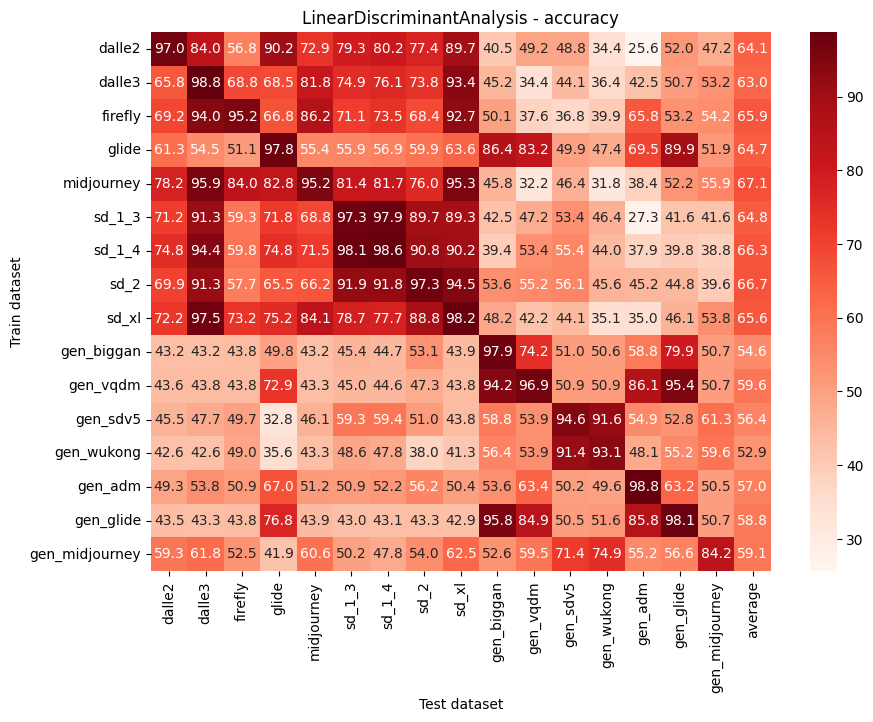

test_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.975000  0.781667  0.570000  0.882500    0.744167  0.629167   
dalle3          0.616667  0.983333  0.696667  0.510000    0.760833  0.785833   
firefly         0.651667  0.937500  0.952500  0.527500    0.778333  0.800833   
glide           0.605833  0.548333  0.541667  0.960000    0.569167  0.492500   
midjourney      0.840833  0.944167  0.831667  0.751667    0.944167  0.777500   
sd_1_3          0.578333  0.866667  0.702500  0.516667    0.660000  0.974167   
sd_1_4          0.585000  0.884167  0.702500  0.513333    0.668333  0.975833   
sd_2            0.555000  0.744167  0.613333  0.494167    0.545833  0.817500   
sd_xl           0.621667  0.929167  0.770833  0.546667    0.735000  0.735000   
gen_biggan      0.527500  0.504167  0.510833  0.861667    0.520000  0.460000   
gen_vqdm        0.489167  0.487500  0.489167  0.791667    0.484167  0.489167   
gen_sdv5        0.427500  0.495833  0.485833  0.252500    0.444167  0.593333   
gen_wukong      0.368333  0.430833  0.489167  0.209167    0.412500  0.524167   
gen_adm         0.521667  0.473333  0.508333  0.604167    0.491667  0.492500   
gen_glide       0.499167  0.489167  0.494167  0.848333    0.495000  0.462500   
gen_midjourney  0.520833  0.454167  0.455833  0.276667    0.574167  0.335000   

test_dataset      sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.631667  0.671667  0.805833     0.40125   0.40125   0.48500   
dalle3          0.773333  0.745833  0.834167     0.38250   0.36750   0.53500   
firefly         0.791667  0.768333  0.932500     0.48125   0.35875   0.47375   
glide           0.500000  0.505833  0.563333     0.98500   0.68375   0.49750   
midjourney      0.777500  0.674167  0.939167     0.50375   0.26500   0.55250   
sd_1_3          0.972500  0.928333  0.830833     0.42750   0.47125   0.62750   
sd_1_4          0.975833  0.935833  0.839167     0.43625   0.48000   0.63500   
sd_2            0.824167  0.972500  0.847500     0.54500   0.50375   0.50125   
sd_xl           0.738333  0.910000  0.972500     0.53750   0.34000   0.48625   
gen_biggan      0.467500  0.465833  0.519167     0.99750   0.60500   0.50000   
gen_vqdm        0.490000  0.487500  0.480833     0.72500   0.99375   0.49875   
gen_sdv5        0.587500  0.517500  0.420000     0.44500   0.44750   0.93375   
gen_wukong      0.504167  0.380000  0.357500     0.46750   0.46875   0.89875   
gen_adm         0.499167  0.476667  0.507500     0.53875   0.54000   0.50000   
gen_glide       0.467500  0.445833  0.494167     0.99500   0.67500   0.50000   
gen_midjourney  0.330833  0.300000  0.469167     0.44125   0.45000   0.60250   

test_dataset    gen_wukong  gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                             
dalle2             0.26750  0.34375    0.49250         0.52375  0.600417  
dalle3             0.47125  0.38750    0.38500         0.46375  0.606198  
firefly            0.48125  0.46875    0.39625         0.43875  0.639974  
glide              0.49000  0.59375    0.97375         0.48875  0.624948  
midjourney         0.43625  0.29000    0.43875         0.55125  0.657396  
sd_1_3             0.55750  0.43125    0.32125         0.38625  0.640781  
sd_1_4             0.54750  0.42250    0.30125         0.37250  0.642187  
sd_2               0.43000  0.42000    0.34750         0.38250  0.596510  
sd_xl              0.38375  0.39250    0.35625         0.45500  0.619401  
gen_biggan         0.50000  0.50750    0.98875         0.50000  0.589714  
gen_vqdm           0.49500  0.96500    0.88875         0.49500  0.609401  
gen_sdv5           0.92000  0.45500    0.46125         0.52250  0.525573  
gen_wukong         0.94000  0.47875    0.48000         0.50375  0.49

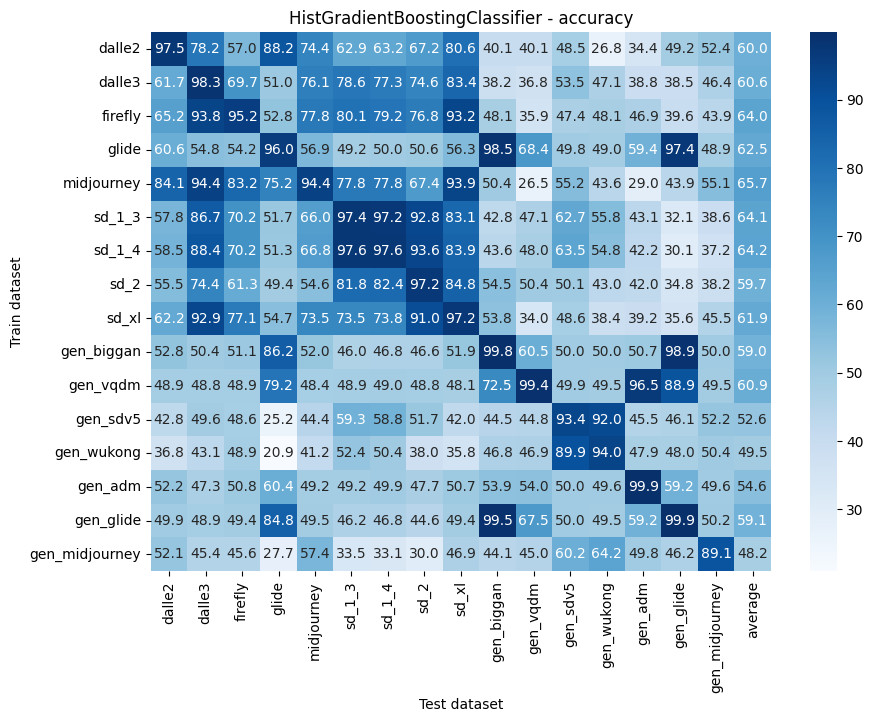

test_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.953333  0.758333  0.564167  0.892500    0.765833  0.538333   
dalle3          0.594167  0.958333  0.700833  0.515000    0.745833  0.750833   
firefly         0.610000  0.930000  0.926667  0.519167    0.758333  0.799167   
glide           0.585000  0.520000  0.535000  0.930833    0.564167  0.461667   
midjourney      0.766667  0.907500  0.777500  0.715833    0.902500  0.723333   
sd_1_3          0.559167  0.864167  0.746667  0.501667    0.675833  0.955833   
sd_1_4          0.561667  0.868333  0.748333  0.493333    0.681667  0.953333   
sd_2            0.513333  0.701667  0.622500  0.480000    0.535000  0.774167   
sd_xl           0.564167  0.884167  0.771667  0.495000    0.677500  0.687500   
gen_biggan      0.522500  0.493333  0.504167  0.861667    0.521667  0.448333   
gen_vqdm        0.482500  0.482500  0.482500  0.822500    0.480833  0.482500   
gen_sdv5        0.480833  0.603333  0.580833  0.317500    0.523333  0.655833   
gen_wukong      0.388333  0.494167  0.495833  0.225000    0.407500  0.550833   
gen_adm         0.484167  0.484167  0.484167  0.831667    0.484167  0.483333   
gen_glide       0.500833  0.491667  0.500000  0.850000    0.498333  0.457500   
gen_midjourney  0.548333  0.418333  0.441667  0.365833    0.560833  0.367500   

test_dataset      sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.537500  0.542500  0.764167     0.45000   0.36750   0.49000   
dalle3          0.724167  0.660833  0.803333     0.41750   0.40375   0.50500   
firefly         0.793333  0.690000  0.910000     0.46125   0.36750   0.48625   
glide           0.465000  0.461667  0.537500     0.96125   0.63500   0.49500   
midjourney      0.716667  0.570833  0.907500     0.48000   0.39000   0.55625   
sd_1_3          0.946667  0.886667  0.815833     0.39625   0.42250   0.62000   
sd_1_4          0.950000  0.894167  0.825000     0.38750   0.40750   0.62375   
sd_2            0.782500  0.953333  0.780833     0.49875   0.45875   0.48375   
sd_xl           0.686667  0.765833  0.949167     0.52000   0.45375   0.45375   
gen_biggan      0.457500  0.435000  0.516667     0.99750   0.63500   0.50000   
gen_vqdm        0.482500  0.482500  0.481667     0.97375   0.98500   0.49500   
gen_sdv5        0.651667  0.551667  0.505833     0.42750   0.43000   0.87750   
gen_wukong      0.537500  0.418333  0.357500     0.43750   0.44750   0.84750   
gen_adm         0.483333  0.480000  0.484167     0.97750   0.92500   0.49750   
gen_glide       0.465833  0.435833  0.495833     0.99500   0.70625   0.50000   
gen_midjourney  0.365833  0.363333  0.440000     0.41375   0.44500   0.50625   

test_dataset    gen_wukong  gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                             
dalle2             0.28875  0.43000    0.54500         0.55500  0.590182  
dalle3             0.49625  0.44250    0.41875         0.47125  0.600521  
firefly            0.51000  0.45250    0.41125         0.44750  0.629557  
glide              0.49125  0.56750    0.97625         0.49500  0.605130  
midjourney         0.45750  0.38625    0.45750         0.51875  0.639661  
sd_1_3             0.55750  0.41250    0.35875         0.41625  0.633516  
sd_1_4             0.56250  0.41250    0.32125         0.39625  0.630443  
sd_2               0.43750  0.41500    0.37125         0.39750  0.575365  
sd_xl              0.42375  0.48125    0.37500         0.44000  0.601823  
gen_biggan         0.49875  0.51000    0.99125         0.49875  0.587005  
gen_vqdm           0.49000  0.98500    0.98125         0.49875  0.630547  
gen_sdv5           0.88500  0.42375    0.44000         0.48375  0.552396  
gen_wukong         0.90625  0.45750    0.46000         0.48750  0.49

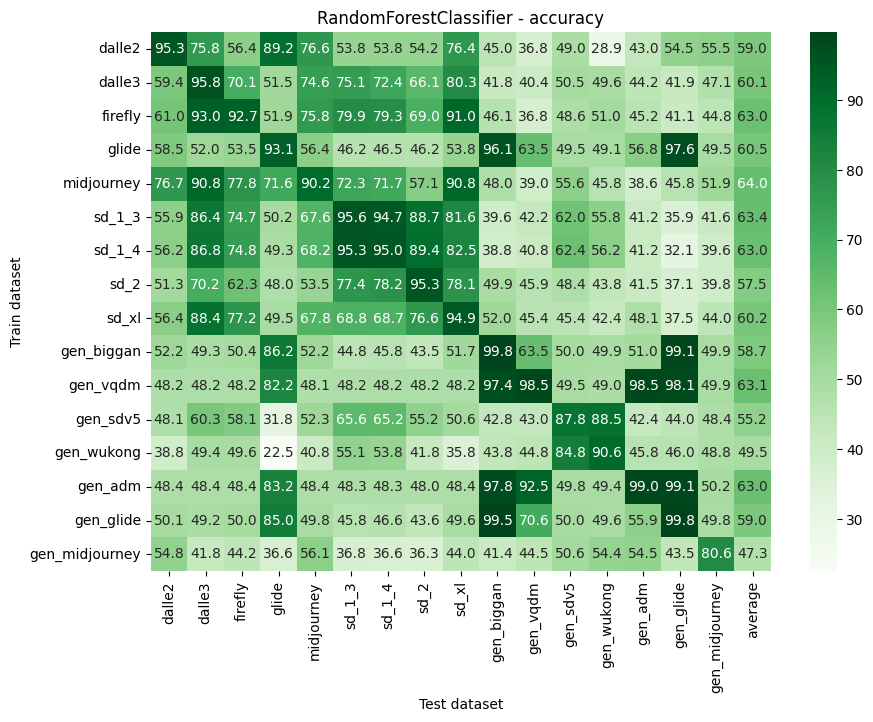

test_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.953333  0.903333  0.650833  0.873333    0.815833  0.756667   
dalle3          0.605000  0.991667  0.724167  0.553333    0.802500  0.730000   
firefly         0.620000  0.940000  0.963333  0.567500    0.843333  0.708333   
glide           0.593333  0.542500  0.536667  0.960000    0.557500  0.527500   
midjourney      0.731667  0.958333  0.870833  0.723333    0.950833  0.729167   
sd_1_3          0.611667  0.909167  0.674167  0.540833    0.672500  0.976667   
sd_1_4          0.615833  0.910833  0.645000  0.533333    0.648333  0.981667   
sd_2            0.557500  0.810000  0.574167  0.529167    0.555000  0.855833   
sd_xl           0.610000  0.950000  0.807500  0.560000    0.787500  0.688333   
gen_biggan      0.519167  0.495000  0.513333  0.791667    0.524167  0.484167   
gen_vqdm        0.482500  0.482500  0.482500  0.826667    0.482500  0.482500   
gen_sdv5        0.518333  0.512500  0.486667  0.352500    0.485000  0.636667   
gen_wukong      0.468333  0.396667  0.455833  0.318333    0.376667  0.520833   
gen_adm         0.487500  0.487500  0.487500  0.831667    0.487500  0.487500   
gen_glide       0.495000  0.492500  0.494167  0.845833    0.494167  0.487500   
gen_midjourney  0.627500  0.597500  0.533333  0.371667    0.625000  0.478333   

test_dataset      sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.765833  0.742500  0.910000     0.26000   0.52125   0.53000   
dalle3          0.724167  0.660000  0.897500     0.42875   0.43625   0.50000   
firefly         0.719167  0.659167  0.944167     0.39125   0.40375   0.37625   
glide           0.525833  0.550833  0.565833     0.97750   0.73625   0.49000   
midjourney      0.735000  0.633333  0.953333     0.38000   0.35750   0.39000   
sd_1_3          0.979167  0.907500  0.853333     0.32125   0.48625   0.65125   
sd_1_4          0.986667  0.919167  0.847500     0.29500   0.49750   0.60875   
sd_2            0.848333  0.979167  0.877500     0.61000   0.60625   0.53375   
sd_xl           0.702500  0.757500  0.978333     0.44875   0.46375   0.45625   
gen_biggan      0.487500  0.505833  0.543333     0.99750   0.59375   0.49875   
gen_vqdm        0.482500  0.482500  0.482500     0.99250   0.99625   0.49750   
gen_sdv5        0.624167  0.494167  0.493333     0.47625   0.46750   0.96625   
gen_wukong      0.533333  0.385833  0.397500     0.48000   0.47500   0.93875   
gen_adm         0.487500  0.486667  0.487500     0.92000   0.88375   0.49750   
gen_glide       0.487500  0.485833  0.494167     0.99625   0.74250   0.49875   
gen_midjourney  0.479167  0.443333  0.594167     0.47250   0.45500   0.70125   

test_dataset    gen_wukong  gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                             
dalle2             0.40000  0.40375    0.52125         0.52375  0.658229  
dalle3             0.46250  0.41125    0.45375         0.51875  0.618724  
firefly            0.40250  0.66375    0.40750         0.48750  0.631094  
glide              0.48250  0.79250    0.97375         0.49875  0.644453  
midjourney         0.34500  0.51875    0.45125         0.61375  0.646380  
sd_1_3             0.57750  0.41875    0.27125         0.36250  0.638359  
sd_1_4             0.51875  0.40250    0.23750         0.34875  0.624818  
sd_2               0.45000  0.48000    0.43125         0.37875  0.629792  
sd_xl              0.42875  0.67625    0.43250         0.50375  0.640729  
gen_biggan         0.50000  0.50625    0.94625         0.49625  0.587682  
gen_vqdm           0.49750  0.93375    0.98500         0.49875  0.630495  
gen_sdv5           0.96250  0.47750    0.49250         0.54250  0.561771  
gen_wukong         0.96250  0.48125    0.48625         0.50625  0.51

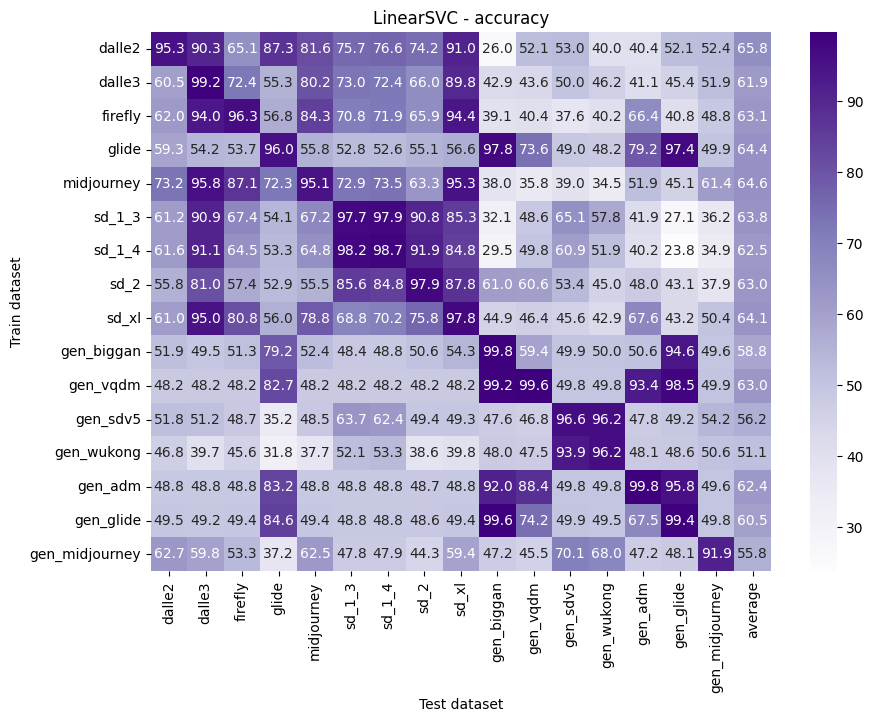

In [24]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "accuracy"
evaluation_data_name = "Test"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

test_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.940467  0.699278  0.228147  0.809479    0.516482  0.621238   
dalle3          0.417421  0.975211  0.466442  0.461067    0.671539  0.562929   
firefly         0.438118  0.880290  0.904497  0.397977    0.729736  0.470631   
glide           0.334713  0.193315  0.090780  0.956692    0.215575  0.227147   
midjourney      0.591267  0.919969  0.691743  0.669825    0.905945  0.646710   
sd_1_3          0.495677  0.831079  0.288817  0.503758    0.456316  0.946819   
sd_1_4          0.562505  0.890728  0.313777  0.562505    0.511479  0.961654   
sd_2            0.478797  0.832312  0.261616  0.406095    0.418691  0.842934   
sd_xl           0.514003  0.950100  0.530027  0.562012    0.705535  0.616814   
gen_biggan     -0.224568 -0.228787 -0.196353  0.011672   -0.224568 -0.129216   
gen_vqdm       -0.127641 -0.124170 -0.124170  0.482512   -0.132863 -0.098355   
gen_sdv5       -0.088139 -0.044486 -0.004769 -0.375887   -0.076307  0.185805   
gen_wukong     -0.149559 -0.149559 -0.017214 -0.311169   -0.133529 -0.025546   
gen_adm        -0.001453  0.106992  0.038917  0.364383    0.045044  0.038917   
gen_glide      -0.129427 -0.132914 -0.124210  0.584366   -0.120741 -0.139912   
gen_midjourney  0.186253  0.235995  0.052303 -0.164475    0.211025  0.006252   

test_dataset      sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.636375  0.589797  0.798822   -0.229332 -0.023509 -0.042139   
dalle3          0.581315  0.544548  0.871641   -0.096669 -0.328412 -0.117854   
firefly         0.511323  0.425297  0.853280    0.002516 -0.264476 -0.276466   
glide           0.249292  0.309830  0.376240    0.733021  0.665299 -0.003281   
midjourney      0.651025  0.554785  0.907688   -0.087237 -0.355000 -0.074731   
sd_1_3          0.958777  0.800889  0.794935   -0.162899 -0.064622  0.090652   
sd_1_4          0.971717  0.824097  0.813829   -0.223320  0.080664  0.131677   
sd_2            0.841411  0.946663  0.891177    0.075696  0.112316  0.131440   
sd_xl           0.600722  0.786899  0.965453   -0.035798 -0.161960 -0.118627   
gen_biggan     -0.159513  0.096845 -0.192497    0.957503  0.551145  0.051031   
gen_vqdm       -0.106918 -0.051049 -0.124170    0.887846  0.937573  0.060673   
gen_sdv5        0.187476  0.021506 -0.124059    0.256055  0.117675  0.892726   
gen_wukong     -0.042294 -0.252440 -0.176718    0.190342  0.124468  0.828082   
gen_adm         0.068961  0.157155  0.026472    0.160737  0.373298  0.025126   
gen_glide      -0.138160 -0.132914 -0.141667    0.916387  0.726014  0.038132   
gen_midjourney -0.042160  0.081701  0.249411    0.073769  0.232230  0.460652   

test_dataset    gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2           -0.351436 -0.503154   0.061001       -0.072787  0.292420  
dalle3           -0.283640 -0.155786   0.015000        0.065029  0.290611  
firefly          -0.216830  0.319111   0.065081        0.085004  0.332818  
glide            -0.072773  0.400263   0.807579        0.046985  0.345667  
midjourney       -0.365553 -0.232518   0.047251        0.128356  0.349970  
sd_1_3           -0.080846 -0.455821  -0.178632       -0.179353  0.315347  
sd_1_4           -0.130622 -0.250287  -0.218410       -0.233679  0.348020  
sd_2             -0.088536 -0.096403  -0.106844       -0.207844  0.358720  
sd_xl            -0.318552 -0.324329  -0.078189        0.075135  0.329328  
gen_biggan        0.041046  0.294973   0.639781        0.050572  0.083692  
gen_vqdm          0.041662  0.744729   0.907980        0.040810  0.200903  
gen_sdv5          0.833086  0.131739   0.089707        0.277424  0.142472  
gen_wukong        0.862524 -0.076748   0.164565       

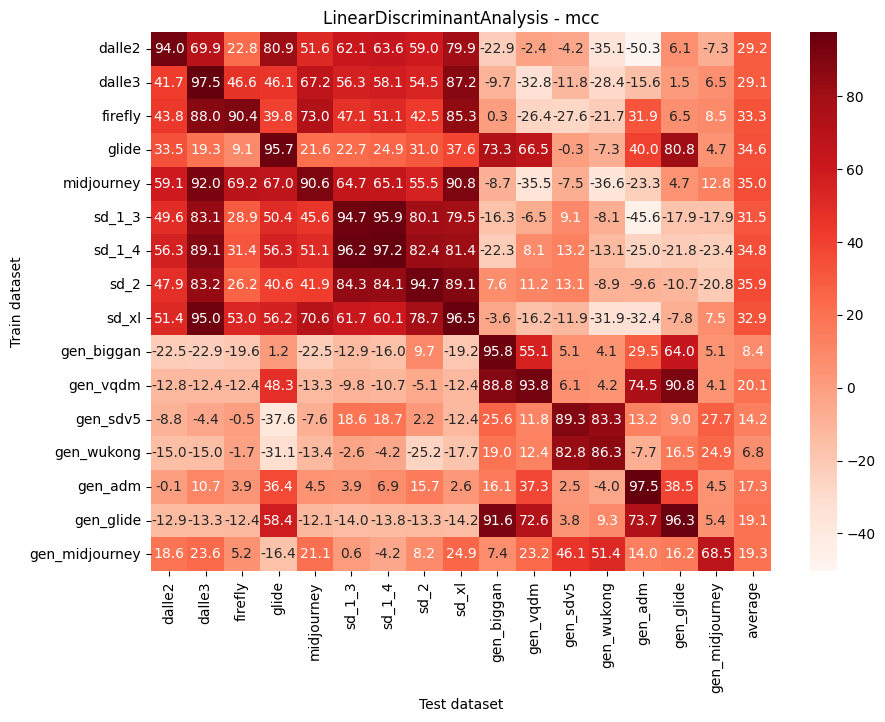

test_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.950221  0.607024  0.240781  0.775767    0.546671  0.355683   
dalle3          0.356242  0.966681  0.487933  0.104746    0.587750  0.626662   
firefly         0.384884  0.875289  0.904971  0.124699    0.595021  0.632190   
glide           0.304377  0.182009  0.165367  0.920035    0.229967  0.003640   
midjourney      0.692785  0.888770  0.676637  0.540069    0.888770  0.583570   
sd_1_3          0.260074  0.748729  0.480615  0.103430    0.410456  0.948458   
sd_1_4          0.273758  0.779136  0.480615  0.092139    0.424452  0.951855   
sd_2            0.230008  0.559567  0.346610  0.021194    0.208173  0.674835   
sd_xl           0.346632  0.861129  0.592287  0.191949    0.535091  0.535091   
gen_biggan      0.073411  0.021540  0.036692  0.731917    0.057080 -0.087818   
gen_vqdm       -0.015980 -0.019536 -0.015980  0.595381   -0.026681 -0.015980   
gen_sdv5       -0.144026 -0.007668 -0.027343 -0.569735   -0.110204  0.186143   
gen_wukong     -0.263056 -0.138482 -0.024116 -0.637775   -0.174558  0.045658   
gen_adm         0.105516 -0.097700  0.063163  0.295956   -0.000706  0.002888   
gen_glide       0.006032 -0.015475 -0.004670  0.725773   -0.002879 -0.075139   
gen_midjourney  0.043134 -0.089832 -0.086425 -0.527510    0.147829 -0.359447   

test_dataset      sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.360129  0.428742  0.646305   -0.244061 -0.251090 -0.050567   
dalle3          0.607171  0.564494  0.703216   -0.288479 -0.318567  0.071162   
firefly         0.616999  0.578608  0.865571   -0.037520 -0.288176 -0.052835   
glide           0.035472  0.057667  0.217069    0.970000  0.460458 -0.050063   
midjourney      0.583570  0.409021  0.878512    0.008704 -0.472612  0.141441   
sd_1_3          0.945073  0.859120  0.688216   -0.149558 -0.057748  0.264836   
sd_1_4          0.951855  0.873246  0.702106   -0.129440 -0.040032  0.284985   
sd_2            0.685519  0.945225  0.723359    0.093609  0.007882  0.002577   
sd_xl           0.540411  0.825944  0.945006    0.075801 -0.334904 -0.027646   
gen_biggan     -0.067927 -0.072293  0.055246    0.995000  0.342518  0.000000   
gen_vqdm       -0.014206 -0.019536 -0.033871    0.521365  0.987577 -0.035377   
gen_sdv5        0.174224  0.034884 -0.159426   -0.241249 -0.235391  0.868938   
gen_wukong      0.005589 -0.239381 -0.285290   -0.183280 -0.179605  0.803552   
gen_adm         0.029948 -0.076742  0.060302    0.194853  0.198288  0.000000   
gen_glide      -0.063663 -0.114527 -0.004670    0.990050  0.455507  0.000000   
gen_midjourney -0.370316 -0.455703 -0.059371   -0.245008 -0.219317  0.268261   

test_dataset    gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2           -0.496397 -0.367840  -0.022678        0.082476  0.222573  
dalle3           -0.062813 -0.267327  -0.275395       -0.082014  0.236341  
firefly          -0.037628 -0.062571  -0.210474       -0.124150  0.297805  
glide            -0.100504  0.289804   0.947527       -0.078008  0.284676  
midjourney       -0.139963 -0.424178  -0.133188        0.120651  0.327660  
sd_1_3            0.115013 -0.141374  -0.396502       -0.245678  0.302072  
sd_1_4            0.095268 -0.157289  -0.435280       -0.270638  0.304796  
sd_2             -0.159586 -0.186656  -0.384906       -0.298024  0.216837  
sd_xl            -0.237419 -0.217806  -0.293582       -0.090961  0.265439  
gen_biggan        0.000000  0.086929   0.977748        0.000000  0.196878  
gen_vqdm         -0.070888  0.930943   0.793122       -0.057953  0.218900  
gen_sdv5          0.841052 -0.217072  -0.200779        0.077658  0.016875  
gen_wukong        0.880099 -0.147348  -0.142857       

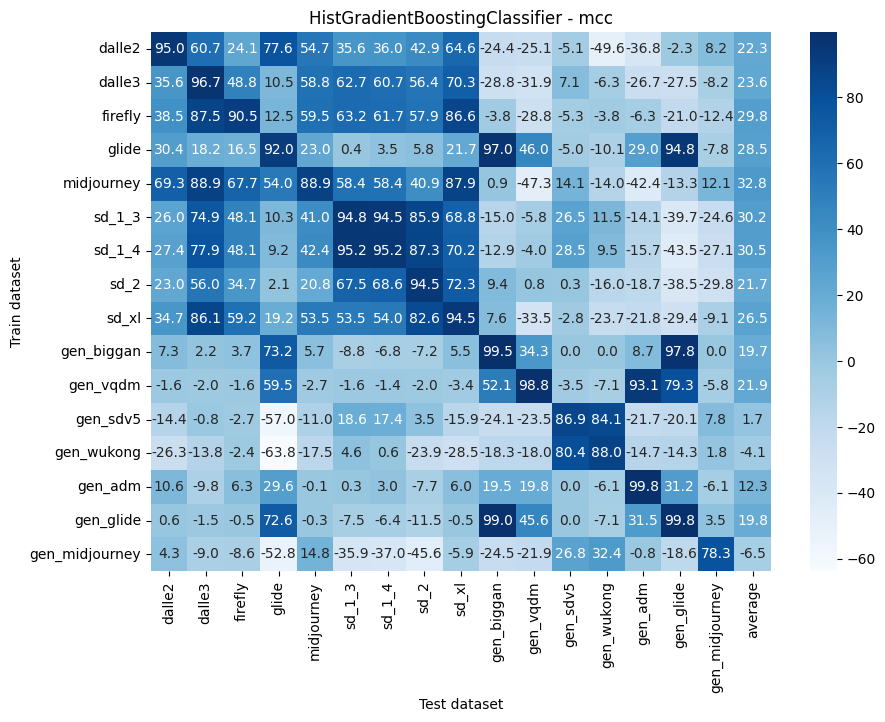

test_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.906913  0.557296  0.208572  0.788860    0.569722  0.147013   
dalle3          0.296839  0.916924  0.481486  0.102398    0.553409  0.561365   
firefly         0.301057  0.860115  0.853579  0.093255    0.556508  0.624685   
glide           0.232492  0.082124  0.120952  0.862508    0.188607 -0.123845   
midjourney      0.555374  0.814979  0.574194  0.467742    0.804927  0.480658   
sd_1_3          0.202245  0.739138  0.541399  0.039415    0.424023  0.911761   
sd_1_4          0.201796  0.744553  0.539931  0.005402    0.428673  0.906993   
sd_2            0.092139  0.479263  0.345158 -0.073442    0.158232  0.595806   
sd_xl           0.205096  0.772678  0.577201  0.011426    0.419575  0.436595   
gen_biggan      0.060375 -0.004419  0.020211  0.736742    0.058586 -0.116462   
gen_vqdm       -0.030470 -0.030470 -0.030470  0.675462   -0.034020 -0.030470   
gen_sdv5       -0.034228  0.208897  0.165348 -0.466379    0.052667  0.311376   
gen_wukong     -0.223023 -0.012984 -0.009706 -0.612873   -0.184122  0.100017   
gen_adm        -0.026873 -0.026873 -0.026873  0.697611   -0.026873 -0.028646   
gen_glide       0.009821 -0.009907  0.008042  0.727790    0.004476 -0.087101   
gen_midjourney  0.109540 -0.190709 -0.128039 -0.360995    0.134411 -0.354708   

test_dataset      sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.144866  0.157571  0.566959   -0.117925 -0.284638 -0.024341   
dalle3          0.518897  0.415903  0.645401   -0.210298 -0.238961  0.010449   
firefly         0.614871  0.442774  0.821444   -0.080548 -0.280726 -0.027507   
glide          -0.107919 -0.123845  0.127115    0.923542  0.375516 -0.070888   
midjourney      0.469178  0.199676  0.814979   -0.042534 -0.223448  0.130563   
sd_1_3          0.893297  0.779366  0.655951   -0.228937 -0.169119  0.240872   
sd_1_4          0.900169  0.791691  0.668600   -0.245495 -0.197889  0.251267   
sd_2            0.609231  0.906922  0.606543   -0.002999 -0.098208 -0.036046   
sd_xl           0.435182  0.567462  0.898608    0.040591 -0.096887 -0.093454   
gen_biggan     -0.092098 -0.153706  0.047783    0.995000  0.392015  0.000000   
gen_vqdm       -0.030470 -0.030470 -0.032243    0.947574  0.970303 -0.070888   
gen_sdv5        0.303143  0.108618  0.017422   -0.279584 -0.274352  0.756857   
gen_wukong      0.073042 -0.162406 -0.287322   -0.258199 -0.235391  0.700059   
gen_adm        -0.028646 -0.035767 -0.026873    0.955012  0.857853 -0.050063   
gen_glide      -0.067666 -0.139902 -0.000896    0.990050  0.503107  0.000000   
gen_midjourney -0.360995 -0.370567 -0.132329   -0.282846 -0.164902  0.016312   

test_dataset    gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2           -0.428930 -0.163324   0.114708        0.164902  0.206764  
dalle3           -0.008410 -0.134159  -0.197359       -0.067682  0.227888  
firefly           0.020502 -0.096959  -0.188927       -0.110632  0.275218  
glide            -0.093953  0.245343   0.952646       -0.035714  0.222168  
midjourney       -0.089718 -0.232071  -0.088279        0.040322  0.292284  
sd_1_3            0.115418 -0.190941  -0.328991       -0.188920  0.277249  
sd_1_4            0.125006 -0.188776  -0.408153       -0.229532  0.268390  
sd_2             -0.151498 -0.226285  -0.366981       -0.302330  0.158469  
sd_xl            -0.165425 -0.038293  -0.270274       -0.128361  0.223232  
gen_biggan       -0.035377  0.100504   0.982577       -0.035377  0.184772  
gen_vqdm         -0.100504  0.970049   0.962527       -0.010734  0.255919  
gen_sdv5          0.772175 -0.287305  -0.252646       -0.057884  0.065258  
gen_wukong        0.813418 -0.210681  -0.204124       

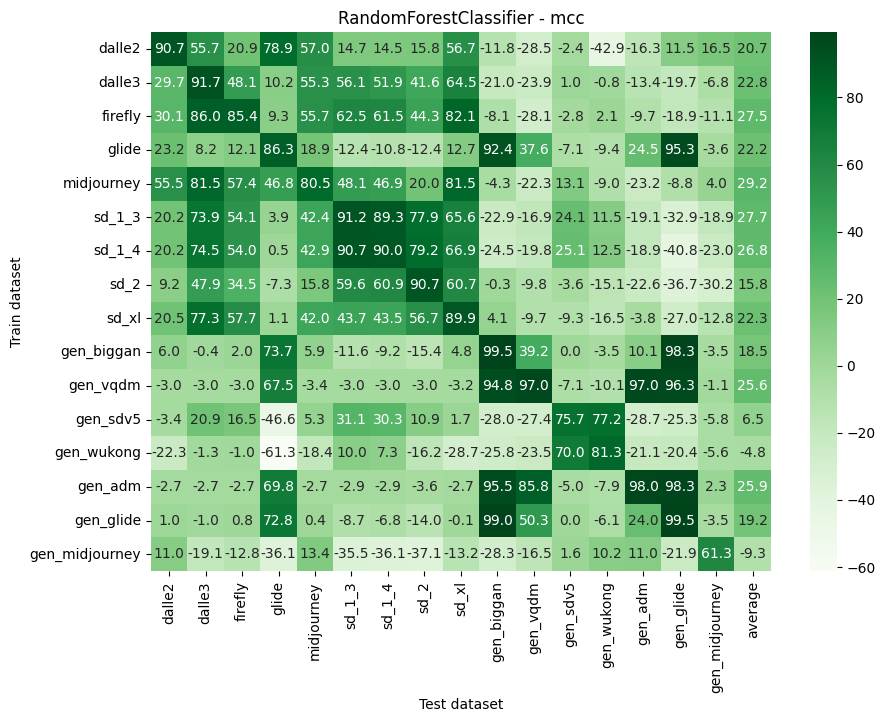

test_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                  
dalle2          0.906644  0.810460  0.383435  0.756190    0.657227  0.559511   
dalle3          0.339353  0.983332  0.533474  0.235934    0.654700  0.542477   
firefly         0.342114  0.881330  0.926672  0.238623    0.709718  0.491213   
glide           0.273503  0.161067  0.146101  0.920344    0.197145  0.121266   
midjourney      0.508117  0.918031  0.747371  0.494170    0.902344  0.503935   
sd_1_3          0.328389  0.824437  0.436738  0.177140    0.433982  0.953436   
sd_1_4          0.347520  0.830003  0.398149  0.170870    0.403756  0.963324   
sd_2            0.238010  0.663757  0.273855  0.166276    0.232319  0.737749   
sd_xl           0.331787  0.901184  0.654598  0.230951    0.622583  0.465116   
gen_biggan      0.094152  0.012205  0.076296  0.612748    0.108723 -0.034027   
gen_vqdm       -0.030470 -0.030470 -0.030470  0.686203   -0.030470 -0.030470   
gen_sdv5        0.046449  0.034332 -0.020855 -0.391798   -0.024514  0.277851   
gen_wukong     -0.060794 -0.227874 -0.087980 -0.465022   -0.281035  0.047775   
gen_adm        -0.019649 -0.019649 -0.019649  0.694455   -0.019649 -0.019649   
gen_glide      -0.003249 -0.008580 -0.005023  0.723984   -0.005023 -0.019315   
gen_midjourney  0.266967  0.209923  0.082271 -0.366319    0.262246 -0.039688   

test_dataset      sd_1_4      sd_2     sd_xl  gen_biggan  gen_vqdm  gen_sdv5  \
train_dataset                                                                  
dalle2          0.574512  0.536356  0.822835   -0.493830  0.057425  0.084017   
dalle3          0.533474  0.432629  0.809512   -0.209323 -0.197067  0.000000   
firefly         0.508651  0.410383  0.889288   -0.241229 -0.217762 -0.262927   
glide           0.116554  0.181497  0.215962    0.955012  0.542908 -0.100504   
midjourney      0.513692  0.338879  0.907546   -0.250384 -0.305482 -0.222188   
sd_1_3          0.958528  0.821429  0.727142   -0.385224 -0.027510  0.333752   
sd_1_4          0.973404  0.844892  0.721948   -0.430513 -0.005036  0.247544   
sd_2            0.725442  0.958393  0.773846    0.220799  0.214691  0.068928   
sd_xl           0.487871  0.575019  0.956668   -0.122490 -0.088425 -0.098120   
gen_biggan     -0.018914  0.051738  0.159649    0.995000  0.321634 -0.035377   
gen_vqdm       -0.030470 -0.030470 -0.030470    0.985049  0.992528 -0.050063   
gen_sdv5        0.253999 -0.004551 -0.006350   -0.119426 -0.176842  0.932503   
gen_wukong      0.072667 -0.256199 -0.225738   -0.134859 -0.160128  0.879506   
gen_adm        -0.019649 -0.021423 -0.019649    0.849613  0.787234 -0.050063   
gen_glide      -0.019315 -0.022917 -0.005023    0.992503  0.561915 -0.035377   
gen_midjourney -0.037704 -0.128430  0.203516   -0.123300 -0.197386  0.447611   

test_dataset    gen_wukong   gen_adm  gen_glide  gen_midjourney   average  
train_dataset                                                              
dalle2           -0.219823 -0.211316   0.053250        0.062331  0.333701  
dalle3           -0.101029 -0.285072  -0.127378        0.044470  0.261843  
firefly          -0.221594  0.329592  -0.197102       -0.025927  0.285065  
glide            -0.118002  0.627042   0.947503       -0.006111  0.323830  
midjourney       -0.334403  0.037506  -0.098813        0.229226  0.305597  
sd_1_3            0.158893 -0.163278  -0.499771       -0.281585  0.299781  
sd_1_4            0.038105 -0.195352  -0.561578       -0.307667  0.277461  
sd_2             -0.111666 -0.042296  -0.151319       -0.297039  0.291984  
sd_xl            -0.188047  0.354366  -0.158618        0.008563  0.308313  
gen_biggan        0.000000  0.067110   0.897702       -0.061352  0.202955  
gen_vqdm         -0.050063  0.872556   0.970000       -0.015861  0.259162  
gen_sdv5          0.925417 -0.137585  -0.053571        0.152394  0.105466  
gen_wukong        0.925289 -0.138233  -0.118075       

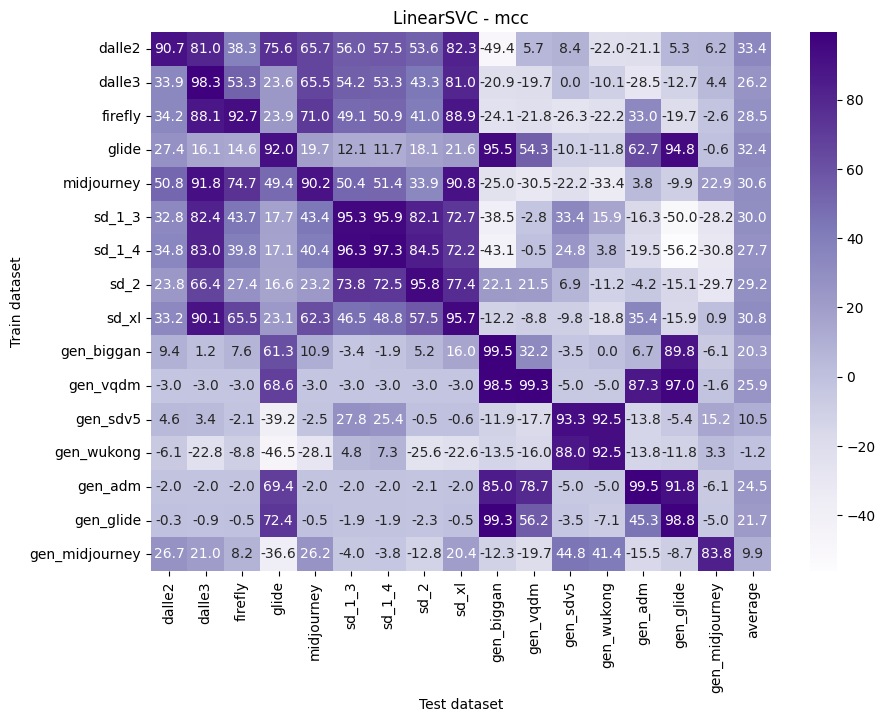

In [25]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "mcc"
evaluation_data_name = "Test"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

## Safe models and scalers

In [26]:
# for each dataset save models and scalers
import joblib

for dataset_name in models.keys():
    for model_name, model in models[dataset_name].items():
        models_dir_path = f"models/synthbusterAugmentedGenImage512jpg100/standard/{dataset_name}"
        scalers_dir_path = f"scalers/synthbusterAugmentedGenImage512jpg100/standard/{dataset_name}"
        os.makedirs(models_dir_path, exist_ok=True)
        os.makedirs(scalers_dir_path, exist_ok=True)
        joblib.dump(model, os.path.join(models_dir_path, f"{dataset_name}_{model_name}.joblib"))
        joblib.dump(scalers[dataset_name], os.path.join(scalers_dir_path, f"{dataset_name}_{model_name}.joblib"))